(GLM-ordinal-features.ipynb)=
# GLM-ordinal-features

:::{post} Oct 27, 2024
:tags: ordinal-features, ordinal-regression, glm, bayesian-workflow, r-datasets
:category: beginner, reference
:author: Jonathan Sedar
:::

## Ordinal Exogenous Feature: Worked Example with Bayesian Workflow

Here we use an **ordinal exogenous predictor feature** within a model:

```
y ~ x + e
y: Numeric
x: Ordinal Category
```

... this is in contrast to estimating an **ordinal endogenous target feature**,
which we show in another notebook


**Disclaimer:**
+ This Notebook is a worked example only, it's not intended to be an academic reference
+ The theory and math may be incorrect, incorrectly notated, or incorrectly used
+ The code may contain errors, inefficiencies, legacy methods, and the text may have typos
+ Use at your own risk!

## Contents

+ [Discussion](#Discussion)

+ [Setup](#Setup)

+ [0. Curate Dataset](#0.-Curate-Dataset)

+ [1. Model A: The Wrong Way - Simple Linear Coefficients](#1.-Model-A:-The-Wrong-Way---Simple-Linear-Coefficients)

+ [2. Model B: A Better Way - Dirichlet Hyperprior Allocator](#2.-Model-B:-A-Better-Way---Dirichlet-Hyperprior-Allocator)

---

---

# Discussion

## Problem Statement

+ Human action and economics is all about expressing our ordinal preferences between limited options in the real-world.
+ We often encounter situations (and datasets) where a predictior feature is an ordinal category, recorded either:
  + As a totally subjective opinion which might be different between observations e.g. "bad, good, better, way better,
    best, actually the best, magnificent"  - these are difficult to work with and a symptom of poor survey design
  + On a partially subjective, standardized scale e.g. "strongly agree, agree, disagree, strongly disagree" - this is
    the approach of the familar [Likert scale](https://en.wikipedia.org/wiki/Likert_scale)
  + As a summary binning of a metric scale e.g. binning ages into age-groups [<30, 30 - 60, 60+], or medical
    self-scoring "[0-10%, ..., 90-100%]" - these are typically a misuse of the metric because the data has been
    compressed: losing infomation, and reasoning for the binning and the choices of bin-edges are usually not given
+ This latter binning is common practice in many industries from insurance to health, and erroneously encourages
  modellers to incorporate such features as a categorical (very bad choice) or a numeric value (a subtly bad choice).

> Our problem statement is that when faced with ordinal features we want to:
>
> 1) **Infer** a series of cutpoints that transform the ordinals into a linear (polynomial) scale
>
> 2) **Predict** the endogenous feature as usual, having captured the information from the ordinals
    

## Data & Models Demonstrated
    
+ This notebook takes the opportunity to:
  + Demonstrate a general method using a constrained Dirichlet prior, based on
    {cite:p}burkner2018
  + Using the same health dataset as that paper `ICFCoreSetCWP.RData` available
    in an R package [ordPens](https://cran.r-project.org/src/contrib/ordPens_1.1.0.tar.gz )
  + Extend a pymc-specific example by
    Austin Rochford {cite:p}`rochford2018`
  + Demonstrate a reasonably complete Bayesian workflow {cite:p}`gelman2020bayesian` including
    data curation and grabbing data from an RDataset which is characteristically ugly

+ This notebook is a partner to another notebook (TBD) where we estimate an **ordinal endogenous target feature**.

---

---

# Setup

:::{include} ../extra_installs.md
:::

In [1]:
# uncomment to install in a Google Colab environment
# !pip install pyreadr watermark

In [2]:
from copy import deepcopy

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pyreadr
import pytensor.tensor as pt

from matplotlib import gridspec
from pymc.testing import assert_no_rvs

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action="ignore", category=FutureWarning)  # isort:skip
import seaborn as sns

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(
    style="darkgrid",
    palette="muted",
    context="notebook",
    rc={"figure.dpi": 72, "savefig.dpi": 144, "figure.figsize": (12, 4)},
)

# set target_accept quite high to minimise divergences in mdlb
SAMPLE_KWS = dict(
    progressbar=True,
    draws=500,
    tune=2000,
    chains=4,
    target_accept=0.8,
    idata_kwargs=dict(log_likelihood=True),
)

USE_LOCAL_DATASET = False

---

---

# 0. Curate Dataset

## 0.1 Extract

Annoyingly but not suprisingly for an R project, despite being a small, simple table, the dataset is only available in a
highly proprietary and obscure, obsolete R binary format, so we'll download, unpack and store locally as a normal CSV file

In [4]:
if USE_LOCAL_DATASET:
    dfr = pd.read_csv("icf_core_set_cwp.csv", index_col="rownames")
else:
    import os
    import tarfile
    import urllib.request

    url = "https://cran.r-project.org/src/contrib/ordPens_1.1.0.tar.gz"
    filehandle, _ = urllib.request.urlretrieve(url)
    rbytes = tarfile.open(filehandle).extractfile(member="ordPens/data/ICFCoreSetCWP.RData").read()
    fn = "ICFCoreSetCWP.RData"
    with open(fn, "wb") as f:
        f.write(rbytes)
    dfr = pyreadr.read_r(fn)["ICFCoreSetCWP"]
    os.remove(fn)
    dfr.to_csv("icf_core_set_cwp.csv")

In [5]:
print(dfr.shape)
display(pd.concat((dfr.describe(include="all").T, dfr.isnull().sum(), dfr.dtypes), axis=1))
display(dfr.head())

(420, 68)


count       mean       std    min    25%     50%      75%    max  0  \
b1602  420.0   0.542857  0.901111   0.00   0.00   0.000   1.0000   3.00  0   
b122   420.0   0.533333  0.871908   0.00   0.00   0.000   1.0000   4.00  0   
b126   420.0   0.866667  0.982585   0.00   0.00   1.000   2.0000   3.00  0   
b130   420.0   1.180952  1.075045   0.00   0.00   1.000   2.0000   4.00  0   
b134   420.0   1.352381  1.147632   0.00   0.00   1.000   2.0000   4.00  0   
...      ...        ...       ...    ...    ...     ...      ...    ... ..   
e575   420.0   0.350000  1.466857  -4.00   0.00   0.000   1.0000   4.00  0   
e580   420.0   1.080952  1.648929  -4.00   0.00   1.000   2.0000   4.00  0   
e590   420.0   0.190476  1.391040  -4.00   0.00   0.000   0.0000   4.00  0   
s770   420.0   0.890476  1.023544   0.00   0.00   1.000   2.0000   4.00  0   
phcs   420.0  32.407548  8.167084  10.08  26.58  31.865  37.5475  53.17  0   

             1  
b1602    int32  
b122     int32  
b126     int32  
b130     int32  
b134     int32  
...        ...  
e575     int32  
e580     int32  
e590     int32  
s770     int32  
phcs   float64  

[68 rows x 10 columns]

b1602  b122  b126  b130  b134  b140  b147  b152  b164  b180  ...  \
rownames                                                               ...   
1             0     1     2     1     1     0     0     2     0     0  ...   
2             3     2     2     3     3     2     3     3     3     1  ...   
3             0     1     2     1     1     0     1     2     0     0  ...   
4             0     0     0     2     1     0     0     0     0     0  ...   
5             0     0     0     0     0     0     0     0     0     0  ...   

          e450  e455  e460  e465  e570  e575  e580  e590  s770   phcs  
rownames                                                               
1            4     0     0     0     3     3     4     3     0  44.33  
2            3     3     2     2     2     2     2     2     2  21.09  
3            4     0     0     0     3     3     4     0     0  41.74  
4            2     2    -1     0     0     2     2     1     1  33.96  
5            1     0     0     0     0     0     0     0     0  46.29  

[5 rows x 68 columns]

**Observe:**

+ Looks okay - if this was a prpper project we'd want to know what those cryptic column headings actually mean
+ For this purpose we'll only use a couplf of the features so will press ahead

## 0.2 Clean

In [6]:
fts_austin = ["d450", "d455", "phcs"]
df = dfr[fts_austin].copy()
display(pd.concat((df.describe(include="all").T, df.isnull().sum(), df.dtypes), axis=1))
df.head()

count       mean       std    min    25%     50%      75%    max  0  \
d450  420.0   0.940476  0.998223   0.00   0.00   1.000   2.0000   3.00  0   
d455  420.0   1.585714  1.224174   0.00   1.00   2.000   2.0000   4.00  0   
phcs  420.0  32.407548  8.167084  10.08  26.58  31.865  37.5475  53.17  0   

            1  
d450    int32  
d455    int32  
phcs  float64

d450  d455   phcs
rownames                   
1            0     2  44.33
2            3     3  21.09
3            0     2  41.74
4            3     2  33.96
5            0     0  46.29

### ~~0.2.1 Clean Observations~~

In [7]:
# Not needed

### 0.2.2 Clean Features

#### ~~0.2.2.1 Rename Features~~

Nothing really needed, will rename the index when we force dtype and set index

### ~~0.2.2.2 Correct Features~~

In [8]:
# Seems not needed

### 0.2.2.3 Force Datatypes

##### Force `d450` to string representation and ordered categorical dtype (supplied as an int which is unhelpful)

In [9]:
ft = "d450"
idx = df[ft].notnull()
df.loc[idx, ft] = df.loc[idx, ft].apply(lambda x: f"c{x}")
df[ft].unique()

array(['c0', 'c3', 'c1', 'c2'], dtype=object)

In [10]:
lvls = ["c0", "c1", "c2", "c3"]
df[ft] = pd.Categorical(df[ft].values, categories=lvls, ordered=True)
df[ft].cat.categories

Index(['c0', 'c1', 'c2', 'c3'], dtype='object')

##### Force `d455` to string representation and ordered categorical dtype (supplied as an int which is unhelpful)

In [11]:
ft = "d455"
idx = df[ft].notnull()
df.loc[idx, ft] = df.loc[idx, ft].apply(lambda x: f"c{x}")
df[ft].unique()

array(['c2', 'c3', 'c0', 'c1', 'c4'], dtype=object)

In [12]:
lvls = ["c0", "c1", "c2", "c3", "c4"]
df[ft] = pd.Categorical(df[ft].values, categories=lvls, ordered=True)
df[ft].cat.categories

Index(['c0', 'c1', 'c2', 'c3', 'c4'], dtype='object')

### 0.2.2.4 Create and set indexes

In [13]:
df0 = df.reset_index()
df0["oid"] = df0["rownames"].apply(lambda n: f"o{str(n).zfill(3)}")
df = df0.drop("rownames", axis=1).set_index("oid").sort_index()
assert df.index.is_unique

## 0.3 Very limited quick EDA

In [14]:
print(df.shape)
display(pd.concat((df.describe(include="all").T, df.isnull().sum(), df.dtypes), axis=1))
display(df.head())

(420, 3)


count unique  top freq       mean       std    min    25%     50%  \
d450    420      4   c0  189        NaN       NaN    NaN    NaN     NaN   
d455    420      5   c2  113        NaN       NaN    NaN    NaN     NaN   
phcs  420.0    NaN  NaN  NaN  32.407548  8.167084  10.08  26.58  31.865   

          75%    max  0         1  
d450      NaN    NaN  0  category  
d455      NaN    NaN  0  category  
phcs  37.5475  53.17  0   float64

d450 d455   phcs
oid                  
o001   c0   c2  44.33
o002   c3   c3  21.09
o003   c0   c2  41.74
o004   c3   c2  33.96
o005   c0   c0  46.29

### 0.3.1 Univariate

`Numerics`

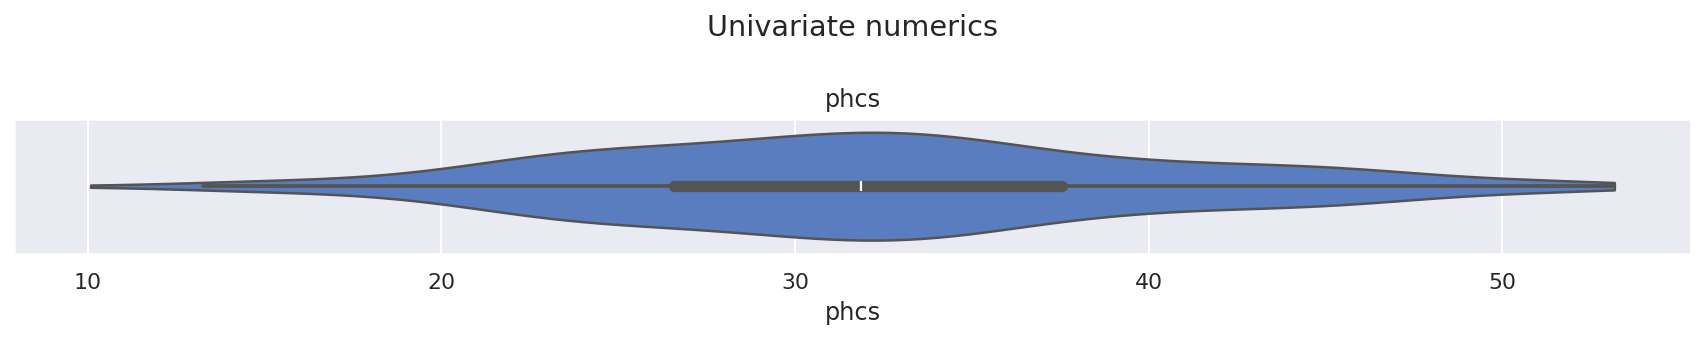

In [15]:
fts = ["phcs"]
v_kws = dict(data=df, cut=0)
cs = sns.color_palette(n_colors=len(fts))
f, axs = plt.subplots(len(fts), 1, figsize=(12, 1 + 1.4 * len(fts)), squeeze=False)
for i, ft in enumerate(fts):
    ax = sns.violinplot(x=ft, **v_kws, ax=axs[0][i], color=cs[i])
    _ = ax.set_title(ft)
_ = f.suptitle("Univariate numerics")
_ = f.tight_layout()

**Observe:**

+ Fairly well-behaved target feature, suitable for use

### 0.3.2 Bivariate `phcs` vs `['d450', 'd455']`

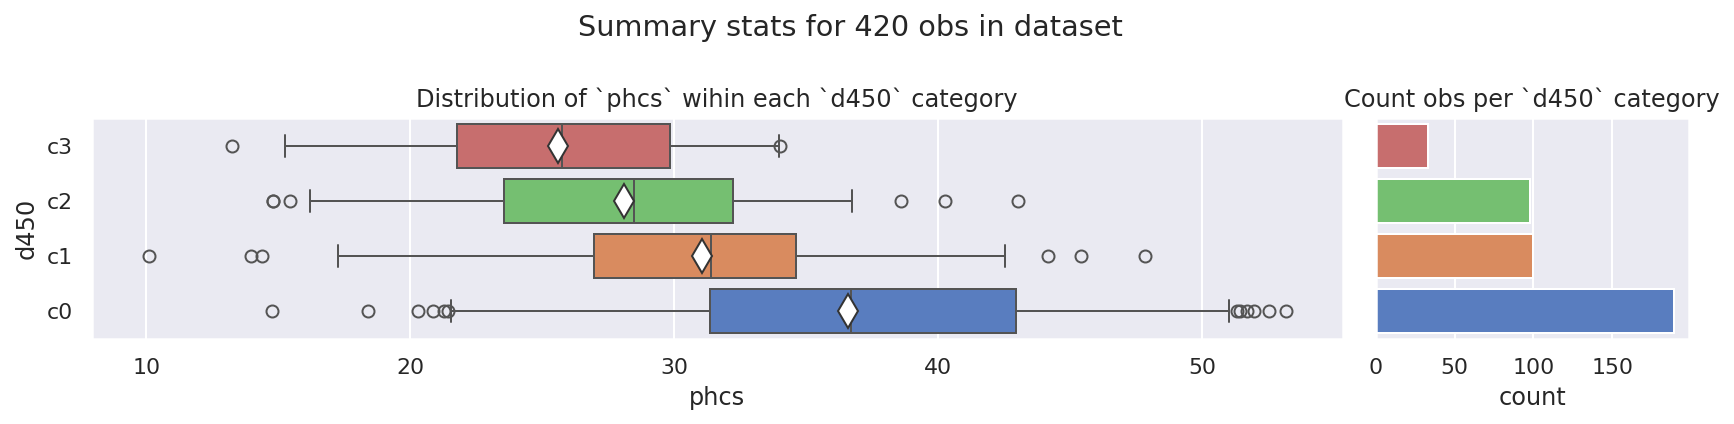

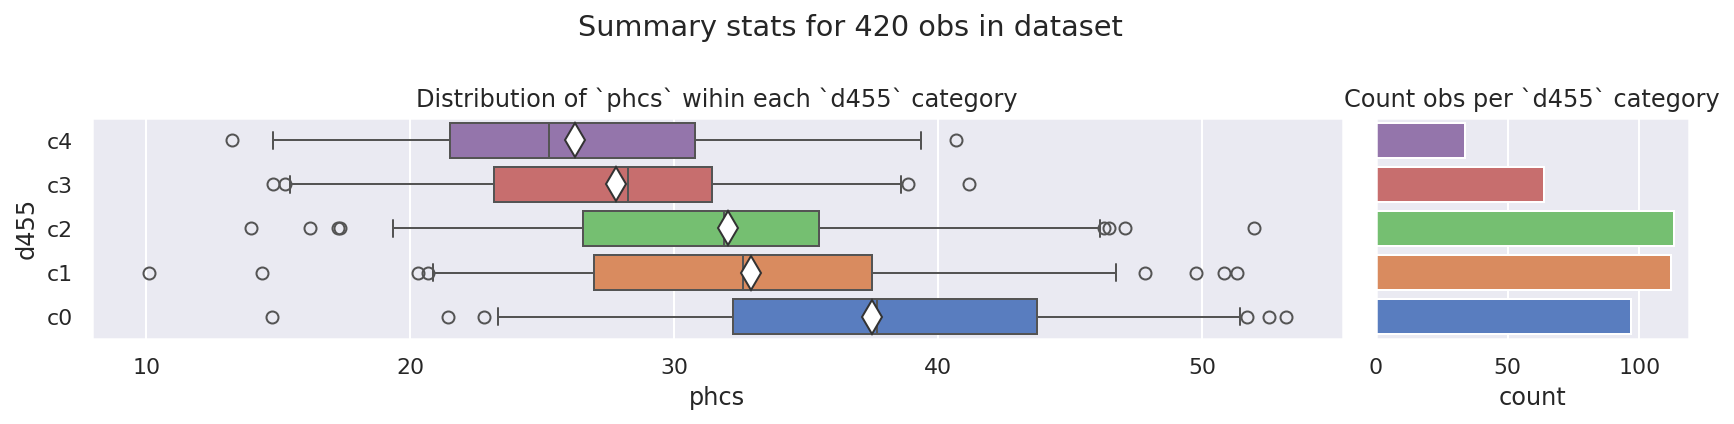

In [16]:
def plot_numeric_vs_cat(df, ftnum="phcs", ftcat="d450") -> plt.figure:
    f = plt.figure(figsize=(12, 3))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1], figure=f)
    ax0 = f.add_subplot(gs[0])
    ax1 = f.add_subplot(gs[1], sharey=ax0)
    _ = ax0.set(title=f"Distribution of `{ftnum}` wihin each `{ftcat}` category")
    _ = ax1.set(title=f"Count obs per `{ftcat}` category", ylabel=False)

    kws_box = dict(
        orient="h",
        showmeans=True,
        whis=(3, 97),
        meanprops=dict(markerfacecolor="w", markeredgecolor="#333333", marker="d", markersize=12),
    )

    _ = sns.boxplot(x=ftnum, y=ftcat, hue=ftcat, data=df, **kws_box, ax=ax0)
    _ = sns.countplot(y=ftcat, hue=ftcat, data=df, ax=ax1)
    _ = ax0.invert_yaxis()
    _ = ax1.yaxis.label.set_visible(False)
    _ = plt.setp(ax1.get_yticklabels(), visible=False)
    _ = f.suptitle(f"Summary stats for {len(df)} obs in dataset")
    _ = f.tight_layout()


f = plot_numeric_vs_cat(df, ftnum="phcs", ftcat="d450")
f = plot_numeric_vs_cat(df, ftnum="phcs", ftcat="d455")

**Observe:**

`phcs vs d450`:
+ `c0` wider and higher: possibly a catch-all category because heavily observed too
+ `c3` fewer counts

`phcs vs d455`:
+ `c1` and `c2` look very similar
+ `c4` fewer counts

## 0.4 Transform dataset to `dfx` for model input

**IMPORTANT NOTE**

+ Reminder that Bayesian inferential methods **do not need** a `test` dataset (nor k-fold cross validation)
  to fit parameters. We also do not need a `holdout` (out-of-sample) dataset to evaluate model performance,
  because we can use in-sample PPC, LOO-PIT and ELPD evaluations
+ So we use the entire dataset `df` as our model input
+ Depending on the real-world model implementation we might:
  + Separate out a `holdout` set (even though we dont need it) to eyeball the predictive outputs, but here we have a summarized dataset, so this isn't possible nor suitable
  + Create a `forecast` set to demonstrate how we would use the model and it's predictive outputs in Production.

**NOTE:**

+ This is an abbreviated / simplified transformation process which still allows
  for the potential to add more features in future

Map ordinal categorical to an ordinal numeric (int) based on its preexisting categorical order

In [17]:
map_int_to_cat_d450 = dict(enumerate(df["d450"].cat.categories))
MAP_CAT_TO_INT_D450 = {v: k for k, v in map_int_to_cat_d450.items()}
df["d450_idx"] = df["d450"].map(MAP_CAT_TO_INT_D450).astype(int)
df["d450_num"] = df["d450_idx"].copy()

map_int_to_cat_d455 = dict(enumerate(df["d455"].cat.categories))
MAP_CAT_TO_INT_D455 = {v: k for k, v in map_int_to_cat_d455.items()}
df["d455_idx"] = df["d455"].map(MAP_CAT_TO_INT_D455).astype(int)
df["d455_num"] = df["d455_idx"].copy()

Transform (zscore and scale) numerics

In [18]:
fts_num = ["d450_num", "d455_num"]
fts_non_num = ["d450_idx", "d455_idx"]
fts_y = ["phcs"]

In [19]:
MNS = np.nanmean(df[fts_num], axis=0)
SDEVS = np.nanstd(df[fts_num], axis=0)
dfx_num = (df[fts_num] - MNS) / SDEVS

icpt = pd.Series(np.ones(len(df)), name="intercept", index=dfx_num.index)

# concat including y_idx which will be used as observed
dfx = pd.concat((df[fts_y], icpt, df[fts_non_num], dfx_num), axis=1)
dfx.sample(5, random_state=42)

phcs  intercept  d450_idx  d455_idx  d450_num  d455_num
oid                                                           
o152  33.40        1.0         0         0 -0.943274 -1.296879
o351  45.42        1.0         1         1  0.059701 -0.479027
o185  31.40        1.0         2         3  1.062676  1.156676
o395  29.01        1.0         2         2  1.062676  0.338824
o449  23.32        1.0         2         0  1.062676 -1.296879

## 0.5 Create `forecast` set and convert to `dffx` for model input

Create `forecast` set

In [20]:
dff = df.groupby(["d450", "d455"]).size().reset_index()[["d450", "d455"]]
lvls_d450 = ["c0", "c1", "c2", "c3"]
dff["d450"] = pd.Categorical(dff["d450"].values, categories=lvls_d450, ordered=True)
lvls_d455 = ["c0", "c1", "c2", "c3", "c4"]
dff["d455"] = pd.Categorical(dff["d455"].values, categories=lvls_d455, ordered=True)
dff["phcs"] = 0.0
dff["oid"] = [f"o{str(n).zfill(3)}" for n in range(len(dff))]
dff.set_index("oid", inplace=True)
dff.head()

d450 d455  phcs
oid                 
o000   c0   c0   0.0
o001   c0   c1   0.0
o002   c0   c2   0.0
o003   c0   c3   0.0
o004   c0   c4   0.0

Convert to `dffx` for model input

In [21]:
dff["d450_idx"] = dff["d450"].map(MAP_CAT_TO_INT_D450).astype(int)
dff["d455_idx"] = dff["d455"].map(MAP_CAT_TO_INT_D455).astype(int)
dff["d450_num"] = dff["d450_idx"].copy()
dff["d455_num"] = dff["d455_idx"].copy()

dffx_num = (dff[fts_num] - MNS) / SDEVS
icptf = pd.Series(np.ones(len(dff)), name="intercept", index=dffx_num.index)

# # concat including y_idx which will be used as observed
dffx = pd.concat((dff[fts_y], icptf, dff[fts_non_num], dffx_num), axis=1)
dffx.sample(5, random_state=42)

phcs  intercept  d450_idx  d455_idx  d450_num  d455_num
oid                                                          
o000   0.0        1.0         0         0 -0.943274 -1.296879
o017   0.0        1.0         3         2  2.065651  0.338824
o015   0.0        1.0         3         0  2.065651 -1.296879
o001   0.0        1.0         0         1 -0.943274 -0.479027
o008   0.0        1.0         1         3  0.059701  1.156676

---

---

# 1. Model A: The Wrong Way - Simple Linear Coefficients

This is a simple linear model where we acknowledge that the categorical features are ordered, but ignore that the
impact of the factor-values on the coefficient might not be equally-spaced, and instead just assume equal spacing:

$$
\begin{align}
\sigma_{\beta} &\sim \text{InverseGamma}(11, 10)  \\
\beta &\sim \text{Normal}(0, \sigma_{\beta}, \text{shape}=j)  \\
\\
\text{lm} &= \beta^{T}\mathbb{x}_{i,j}  \\
\epsilon &\sim \text{InverseGamma}(11, 10)  \\
\hat{y_{i}} &\sim \text{Normal}(\mu=\text{lm}, \epsilon)  \\
\end{align}
$$

where:
+ Observations $i$ contain numeric features $j$, and $\hat{y_{i}}$ is our estimate, here of `phcs`
+ The linear sub-model $\beta^{T}\mathbb{x}_{ij}$ lets us regress onto those features
+ Notably:
    + $\mathbb{x}_{i,d450}$ is treated as a numeric feature
    + $\mathbb{x}_{i,d455}$ is treated as a numeric feature

## 1.1 Build Model Object

In [22]:
ft_y = "phcs"
fts_x = ["intercept", "d450_num", "d455_num"]

COORDS = dict(oid=dfx.index.values, y_nm=ft_y, x_nm=fts_x)

In [23]:
with pm.Model(coords=COORDS) as mdla:
    # 0. create (Mutable)Data containers for obs (Y, X)
    y = pm.Data("y", dfx[ft_y].values, dims="oid")  # (i, )
    x = pm.Data("x", dfx[fts_x].values, dims=("oid", "x_nm"))  # (i, x)

    # 1. define priors for numeric exogs
    b_s = pm.InverseGamma("beta_sigma", alpha=11, beta=10)  # (1, )
    b = pm.Normal("beta", mu=0, sigma=b_s, dims="x_nm")  # (x, )

    # 2. define likelihood
    epsilon = pm.InverseGamma("epsilon", alpha=11, beta=10)
    _ = pm.Normal("phcs_hat", mu=pt.dot(x, b.T), sigma=epsilon, observed=y, dims="oid")

RVS_PPC = ["phcs_hat"]
RVS_SIMPLE_COMMON = ["beta_sigma", "beta", "epsilon"]

# display RVS
display(dict(unobserved=mdla.unobserved_RVs, observed=mdla.observed_RVs))

{'unobserved': [beta_sigma, beta, epsilon], 'observed': [phcs_hat]}

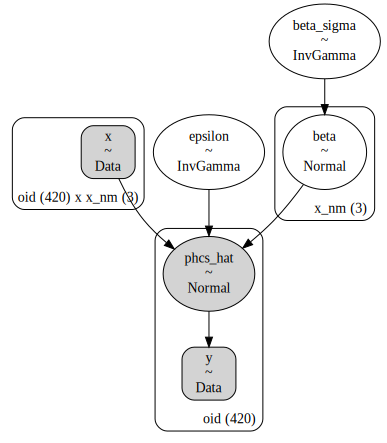

point={'beta_sigma_log__': array(0.), 'beta': array([0., 0., 0.]), 'epsilon_log__': array(0.)}

No problems found
point={'beta_sigma_log__': array(0.), 'beta': array([0., 0., 0.]), 'epsilon_log__': array(0.)}

No problems found


In [24]:
display(pm.model_to_graphviz(mdla, formatting="plain"))
assert_no_rvs(mdla.logp())
mdla.debug(fn="logp", verbose=True)
mdla.debug(fn="random", verbose=True)

## 1.2 Sample Prior Predictive, View Diagnostics

In [25]:
with mdla:
    ida = pm.sample_prior_predictive(
        var_names=RVS_PPC + RVS_SIMPLE_COMMON,
        samples=2000,
        return_inferencedata=True,
        random_seed=42,
    )

### 1.2.1 In-Sample Prior PPC (Retrodictive Check)

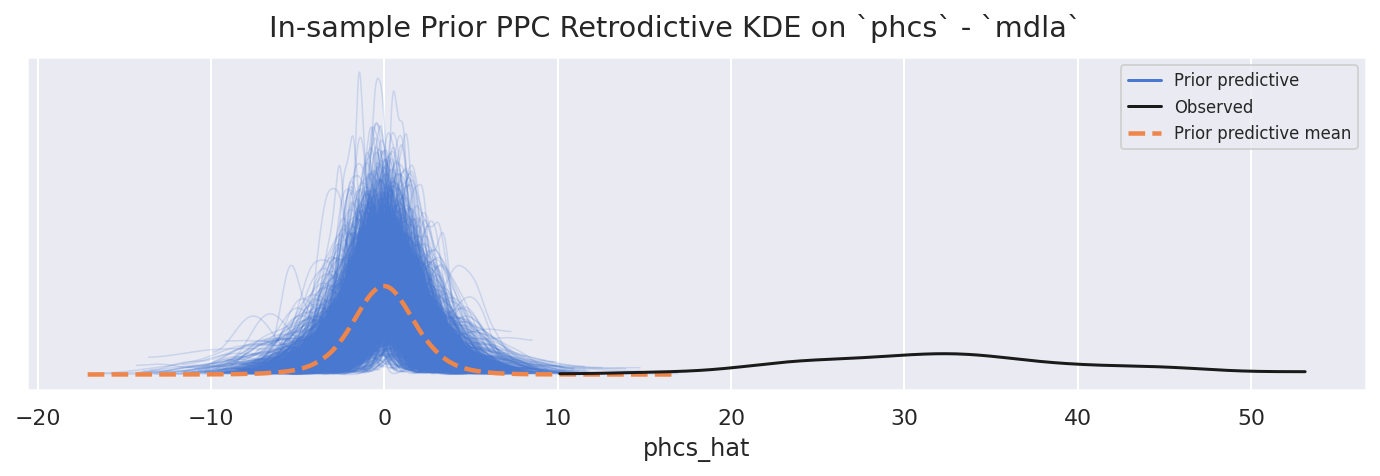

In [26]:
def plot_ppc_retrodictive(idata, group="prior", mdlname="mdla", ynm="y") -> plt.figure:
    """Convenience plot PPC retrodictive KDE"""
    f, axs = plt.subplots(1, 1, figsize=(12, 3))
    _ = az.plot_ppc(idata, group=group, kind="kde", var_names=RVS_PPC, ax=axs, observed=True)
    _ = f.suptitle(f"In-sample {group.title()} PPC Retrodictive KDE on `{ynm}` - `{mdlname}`")
    return f


f = plot_ppc_retrodictive(ida, "prior", "mdla", "phcs")

**Observe:**

+ Values are wrong as expected, but range is reasonable

### 1.2.2 Quick look at selected priors

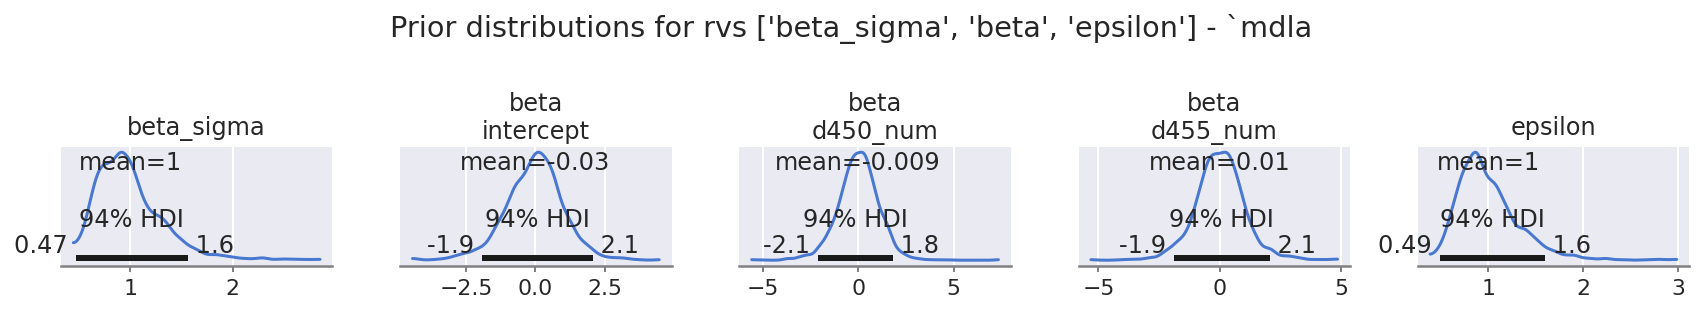

In [27]:
def plot_posterior(
    idata,
    group="prior",
    rvs=RVS_SIMPLE_COMMON,
    coords=None,
    mdlname="mdla",
    n=1,
    nrows=1,
) -> plt.figure:
    """Convenience plot posterior (or prior) KDE"""
    m = int(np.ceil(n / nrows))
    f, axs = plt.subplots(nrows, m, figsize=(2.4 * m, 0.8 + nrows * 1.4))
    _ = az.plot_posterior(idata, group=group, ax=axs, var_names=rvs, coords=coords)
    _ = f.suptitle(f"{group.title()} distributions for rvs {rvs} - `{mdlname}")
    _ = f.tight_layout()
    return f


f = plot_posterior(ida, "prior", rvs=RVS_SIMPLE_COMMON, mdlname="mdla", n=1 + 3 + 1, nrows=1)

**Observe:**

+ `beta_sigma`, `beta: (levels)`, `epsilon` all have reasonable prior ranges as specified

## 1.3 Sample Posterior, View Diagnostics

### 1.3.1 Sample Posterior and PPC

In [28]:
with mdla:
    ida.extend(pm.sample(**SAMPLE_KWS), join="right")
    ida.extend(
        pm.sample_posterior_predictive(trace=ida.posterior, var_names=RVS_PPC),
        join="right",
    )

Output()

Output()

Output()

Output()

Output()

### 1.3.2 Traces

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_sigma        9.589  2.015   6.317   13.378      0.046    0.035    2253.0   
beta[intercept]  32.353  0.334  31.697   32.940      0.007    0.005    2427.0   
beta[d450_num]   -2.986  0.410  -3.704   -2.192      0.010    0.007    1708.0   
beta[d455_num]   -1.789  0.392  -2.516   -1.056      0.010    0.007    1575.0   
epsilon           6.926  0.239   6.488    7.379      0.005    0.003    2384.0   

                 ess_tail  r_hat  
beta_sigma         1426.0    1.0  
beta[intercept]    1344.0    1.0  
beta[d450_num]     1563.0    1.0  
beta[d455_num]     1562.0    1.0  
epsilon            1510.0    1.0

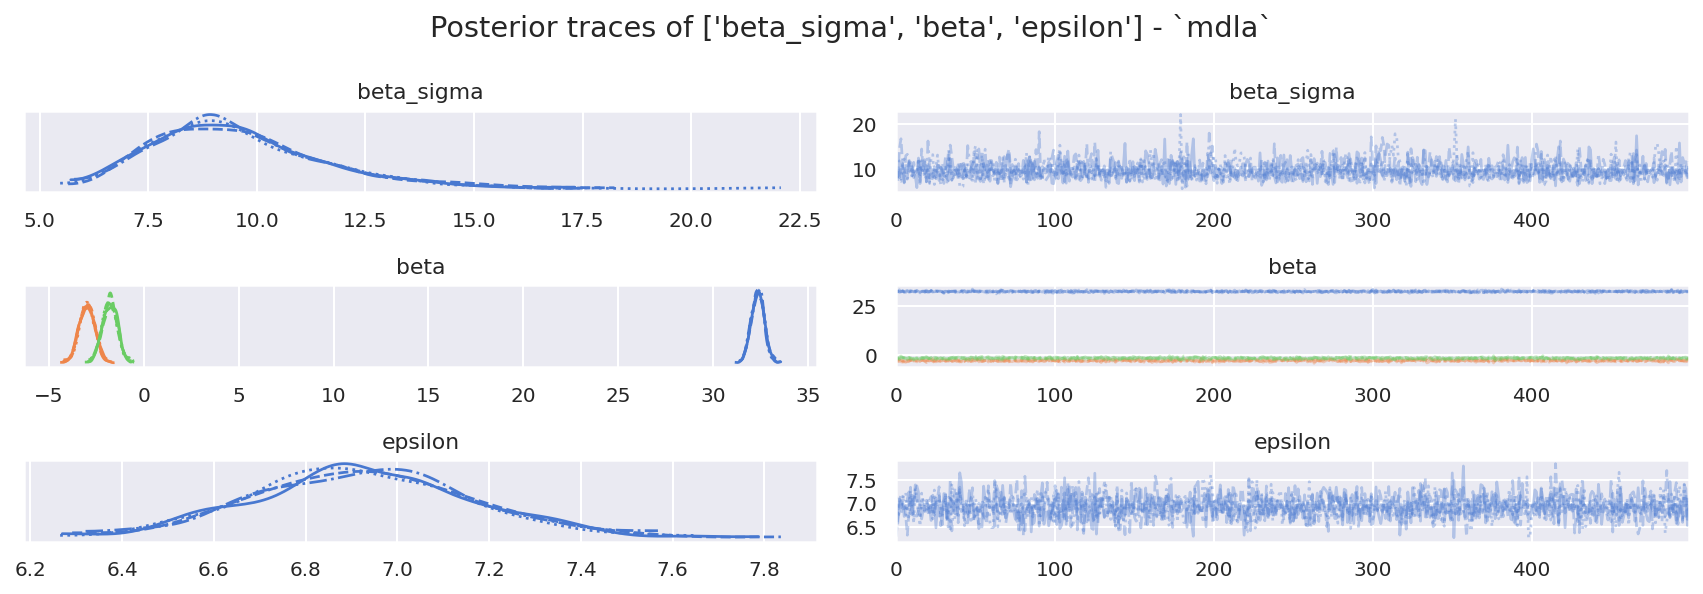

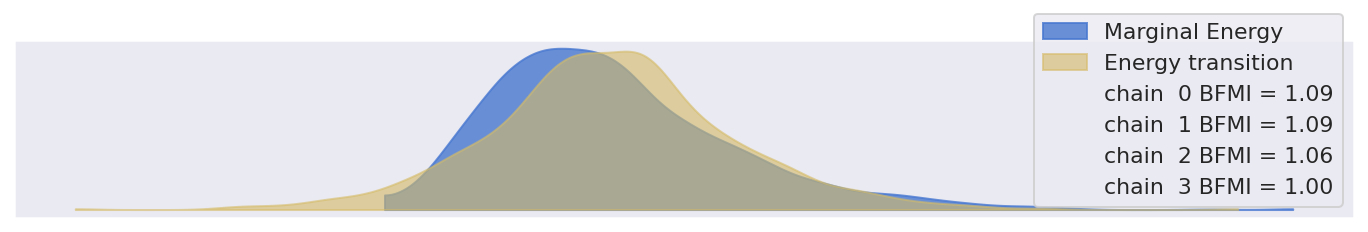

In [29]:
def plot_traces_and_display_summary(idata, rvs, coords=None, mdlname="mdla") -> plt.figure:
    """Convenience to plot traces and display summary table for rvs"""
    _ = az.plot_trace(idata, var_names=rvs, coords=coords, figsize=(12, 1.4 * len(rvs)))
    f = plt.gcf()
    _ = f.suptitle(f"Posterior traces of {rvs} - `{mdlname}`")
    _ = f.tight_layout()
    _ = az.plot_energy(idata, fill_alpha=(0.8, 0.6), fill_color=("C0", "C8"), figsize=(12, 1.6))
    display(az.summary(idata, var_names=rvs))
    return f


f = plot_traces_and_display_summary(ida, rvs=RVS_SIMPLE_COMMON, mdlname="mdla")

**Observe:**

+ Samples well-mixed and well-behaved
  + `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks reasonable
  + `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

### 1.3.3 In-Sample Posterior PPC (Retrodictive Check)

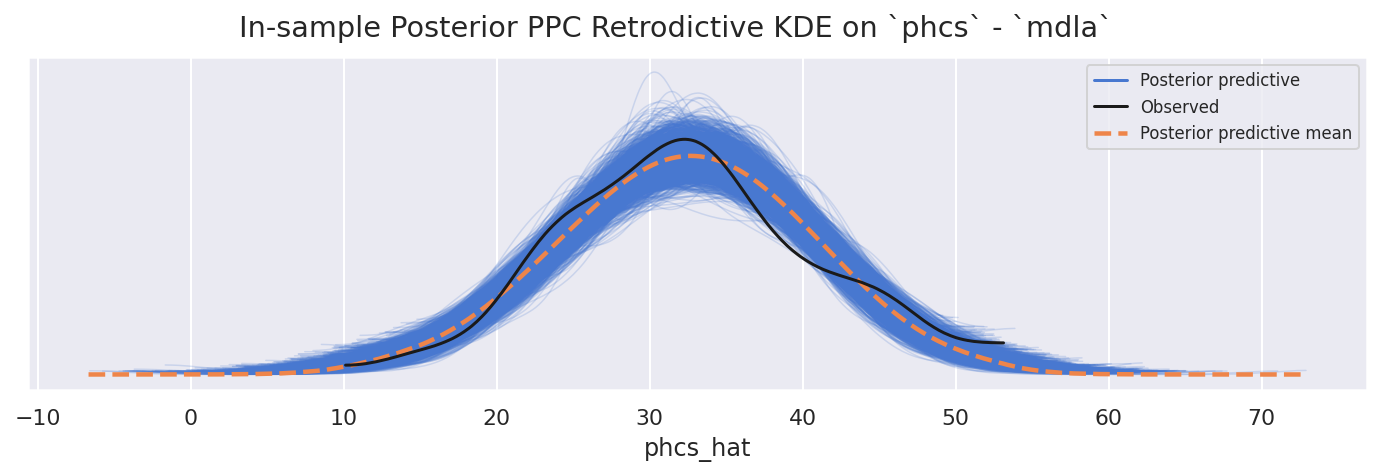

In [30]:
f = plot_ppc_retrodictive(ida, "posterior", "mdla", "phcs")

**Observe:**

+ In-sample PPC `phcs_hat` tracks the observed `phcs` moderately well: slightly overdispersed, perhaps a likelihood
  with fatter tails would be more appropriate (e.g. StudentT)

### 1.3.4 In-Sample PPC LOO-PIT

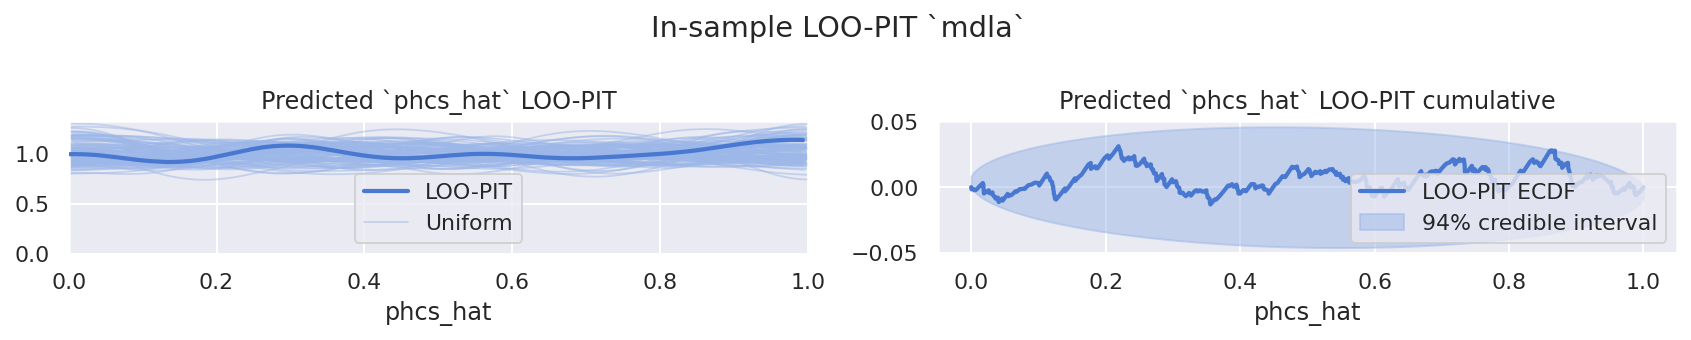

In [31]:
def plot_loo_pit(idata, mdlname="mdla", y="phcs_hat", y_hat="phcs_hat"):
    """Convenience plot LOO-PIT KDE and ECDF"""
    f, axs = plt.subplots(1, 2, figsize=(12, 2.4))
    _ = az.plot_loo_pit(idata, y=y, y_hat=y_hat, ax=axs[0])
    _ = az.plot_loo_pit(idata, y=y, y_hat=y_hat, ax=axs[1], ecdf=True)
    _ = axs[0].set_title(f"Predicted `{y_hat}` LOO-PIT")
    _ = axs[1].set_title(f"Predicted `{y_hat}` LOO-PIT cumulative")
    _ = f.suptitle(f"In-sample LOO-PIT `{mdlname}`")
    _ = f.tight_layout()
    return f


f = plot_loo_pit(ida, "mdla")

**Observe:**

+ `LOO-PIT` looks good, again slightly overdispersed but acceptable for use

### ~~1.3.5 Compare Log-Likelihood vs Other Models~~

In [32]:
# Nothing to compare yet

## 1.4 Evaluate Posterior Parameters

### 1.4.1 Univariate

Lots of parameters, let's take our time

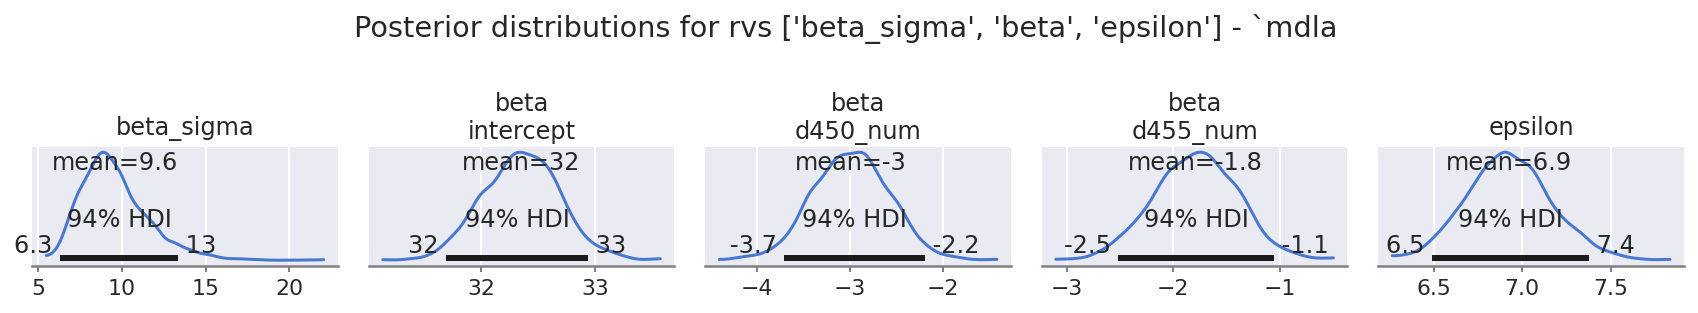

In [33]:
f = plot_posterior(ida, "posterior", rvs=RVS_SIMPLE_COMMON, mdlname="mdla", n=5, nrows=1)

**Observe:**

+ `beta_sigma`: `E ~ 10` indicates need for high variance in lcoations of `beta`s
+ `beta: intercept`: `E ~ 32` confirms the bulk of the variance in `beta`s locations is simply due to the intercept
    offset required to get the zscored values into range of `phcs`, no problem
+ `beta: d450_num`: `E ~ -3` negative, HDI94 does not span 0, substantial effect, smooth central distribution:
  + Higher values of `d450_num` create a reduction in `phcs_hat`
+ `beta: d455_num`: `E ~ -2` negative, HDI94 does not span 0, substantial effect, smooth central distribution
  + Higher values of `d455_num` create a smaller reduction in `phcs_hat`
+ `epsilon`: `E ~ 7` indicates quite a lot of variance still in the data, not yet handled by a modelled feature

## 1.5 Create PPC Forecast on simplified `forecast` set

Just for completeness, just compare to Figure 3 in the Bürkner paper and Rochford's
blogpost. Those plots summarize to a mean though, which seems unneccesary - let's
improve it a little with full sample posteriors

##### Replace dataset with `dffx` and rebuild

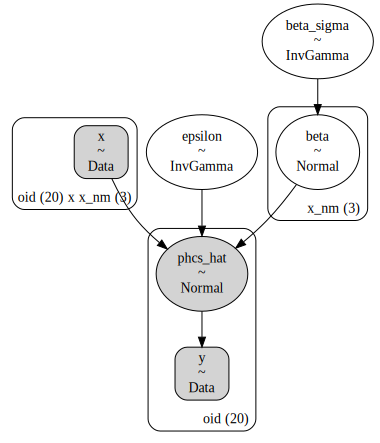

point={'beta_sigma_log__': array(0.), 'beta': array([0., 0., 0.]), 'epsilon_log__': array(0.)}

No problems found
point={'beta_sigma_log__': array(0.), 'beta': array([0., 0., 0.]), 'epsilon_log__': array(0.)}

No problems found


In [34]:
COORDS_F = deepcopy(COORDS)
COORDS_F["oid"] = dffx.index.values
mdla.set_data("y", dffx[ft_y].values, coords=COORDS_F)
mdla.set_data("x", dffx[fts_x].values, coords=COORDS_F)

display(pm.model_to_graphviz(mdla, formatting="plain"))
assert_no_rvs(mdla.logp())
mdla.debug(fn="logp", verbose=True)
mdla.debug(fn="random", verbose=True)

In [35]:
with mdla:
    ida_ppc = pm.sample_posterior_predictive(
        trace=ida.posterior, var_names=RVS_PPC, predictions=True
    )

Output()

### 1.5.2 View Predictions

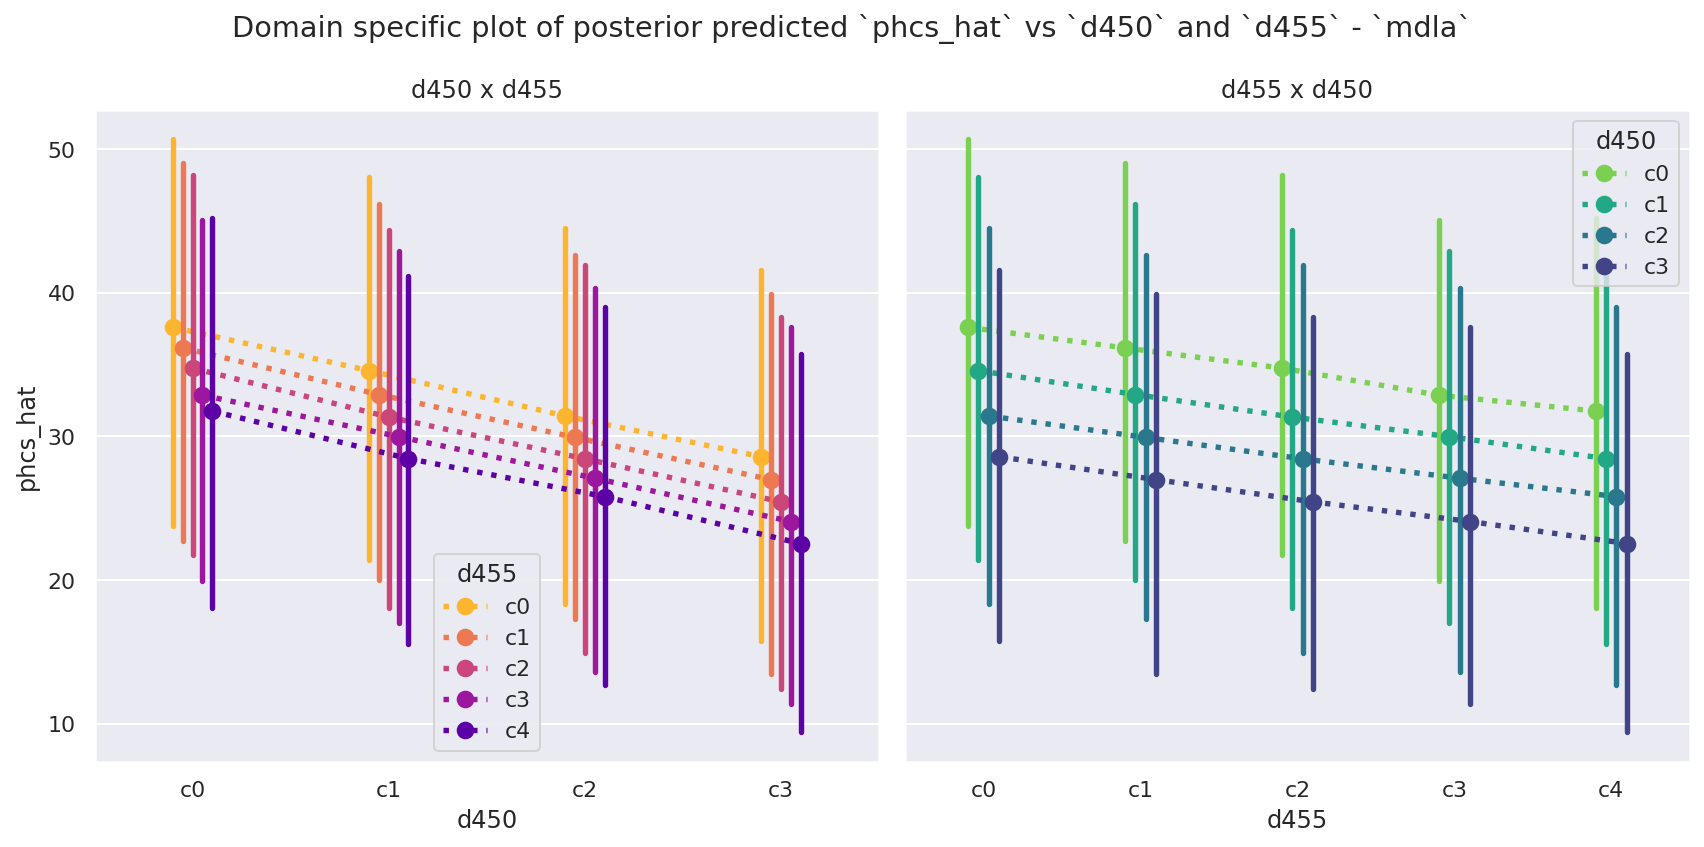

In [36]:
def plot_predicted_phcshat_d450_d455(idata, mdlname) -> plt.Figure:
    """Convenience to plot predicted phcs_hat vs d450 and d455"""
    phcs_hat = (
        az.extract(idata, group="predictions", var_names=["phcs_hat"])
        .to_dataframe()
        .drop(["chain", "draw"], axis=1)
    )
    dfppc = pd.merge(
        phcs_hat.reset_index(),
        dff[["d450", "d455"]].reset_index(),
        how="left",
        on="oid",
    )

    kws = dict(
        y="phcs_hat",
        data=dfppc,
        linestyles=":",
        estimator="mean",
        errorbar=("pi", 94),
        dodge=0.2,
    )

    f, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    _ = sns.pointplot(x="d450", hue="d455", **kws, ax=axs[0], palette="plasma_r")
    _ = sns.pointplot(x="d455", hue="d450", **kws, ax=axs[1], palette="viridis_r")
    _ = [axs[i].set_title(t) for i, t in enumerate(["d450 x d455", "d455 x d450"])]
    _ = f.suptitle(
        "Domain specific plot of posterior predicted `phcs_hat`"
        + f" vs `d450` and `d455` - `{mdlname}`"
    )
    _ = f.tight_layout()


plot_predicted_phcshat_d450_d455(idata=ida_ppc, mdlname="mdla")

**Observe:**

+ Compare this to the plots in
  [Austin Rochford's notebook](https://austinrochford.com/posts/2018-11-10-monotonic-predictors.html)
+ We see the linear responses and equal spacings of `d450` and of `d455` when treated as numeric values
+ Note here we plot the full posteriors on each datapoint (rather than summarise to a mean) which emphasises
  the large amount of variance still in the data & model

---

---

# 2. Model B: A Better Way - Dirichlet Hyperprior Allocator

This is an improved linear model where we acknowledge that the categorical features are ordinal _and_ allow the ordinal
values to have a non-equal spacing, For example, it might well be that `A > B > C`, but the spacing is not metric:
instead `A >>> B > C`. We achieve this using a Dirichlet hyperprior to allocate hetrogenously spaced sections of a
linear ceofficient:

$$
\begin{align}
\sigma_{\beta} &\sim \text{InverseGamma}(11, 10)  \\
\beta &\sim \text{Normal}(0, \sigma_{\beta}, \text{shape}=j)  \\
\\
\beta_{d450} &\sim \text{Normal}(0, \sigma_{\beta})  \\
\chi_{d450} &\sim \text{Dirichlet}(1, \text{shape}=k_{d450})  \\
\nu_{d450} &\sim \beta_{d450} * \sum_{i=0}^{i=k_{d450}}\chi_{d450} \\
\\
\beta_{d455} &\sim \text{Normal}(0, \sigma_{\beta})  \\
\chi_{d455} &\sim \text{Dirichlet}(1, \text{shape}=k_{d455})  \\
\nu_{d455} &\sim \beta_{d455} * \sum_{i=0}^{i=k_{d455}}\chi_{d455} \\
\\
lm &= \beta^{T}\mathbb{x}_{i,j} + \nu_{d450}[x_{i,d450}] + \nu_{d455}[x_{i,d455}]\\
\epsilon &\sim \text{InverseGamma}(11, 10)  \\
\hat{y_{i}} &\sim \text{Normal}(\mu=lm, \epsilon)  \\
\end{align}
$$

where:
+ Observations $i$ contain numeric features $j$ and ordinal categorical features
  $k$ (here `d450, d455`) which each have factor value levels $k_{d450}, k_{d455}$
+ $\hat{y_{i}}$ is our estimate, here of `phcs`
+ The linear sub-model $lm = \beta^{T}\mathbb{x}_{i,j} + \nu_{d450}[x_{i,d450}] + \nu_{d455}[x_{i,d455}]$ lets us
  regress onto those features
+ Notably:
    + $\mathbb{x}_{i,d450}$ is treated as an ordinal feature and used to index $\nu_{d450}[x_{i,d450}]$
    + $\mathbb{x}_{i,d455}$ is treated as an ordinal feature and used to index $\nu_{d455}[x_{i,d455}]$
+ NOTE: The above spec is not particuarly optimised / vectorised / DRY to aid explanation

## 2.1 Build Model Object

In [37]:
ft_y = "phcs"
fts_x = ["intercept"]
# NOTE fts_ord = ['d450_idx', 'd455_idx']

COORDS = dict(
    oid=dfx.index.values,
    y_nm=ft_y,
    x_nm=fts_x,
    d450_nm=list(map_int_to_cat_d450.values()),
    d455_nm=list(map_int_to_cat_d455.values()),
)

In [38]:
with pm.Model(coords=COORDS) as mdlb:
    # NOTE: Spec not particuarly optimised / vectorised / DRY to aid explanation

    # 0. create (Mutable)Data containers for obs (Y, X)
    y = pm.Data("y", dfx[ft_y].values, dims="oid")  # (i, )
    x = pm.Data("x", dfx[fts_x].values, dims=("oid", "x_nm"))  # (i, x)
    idx_d450 = pm.Data("idx_d450", dfx["d450_idx"].values, dims="oid")  # (i, )
    idx_d455 = pm.Data("idx_d455", dfx["d455_idx"].values, dims="oid")  # (i, )

    # 1. define priors for numeric exogs
    b_s = pm.InverseGamma("beta_sigma", alpha=11, beta=10)  # (1, )
    b = pm.Normal("beta", mu=0, sigma=b_s, dims="x_nm")  # (x, )

    # 2. define nu
    def _get_nu(nm, dim):
        """Partition continous prior into ordinal chunks"""
        b0 = pm.Normal(f"beta_{nm}", mu=0, sigma=b_s)  # (1, )
        c0 = pm.Dirichlet(f"chi_{nm}", a=np.ones(len(COORDS[dim])), dims=dim)  # (lvls, )
        return pm.Deterministic(f"nu_{nm}", b0 * c0.cumsum(), dims=dim)  # (lvls, )

    nu_d450 = _get_nu("d450", "d450_nm")
    nu_d455 = _get_nu("d455", "d455_nm")

    # 3. define likelihood
    epsilon = pm.InverseGamma("epsilon", alpha=11, beta=10)
    _ = pm.Normal(
        "phcs_hat",
        mu=pt.dot(x, b.T) + nu_d450[idx_d450] + nu_d455[idx_d455],
        sigma=epsilon,
        observed=y,
        dims="oid",
    )


rvs_simple = RVS_SIMPLE_COMMON + ["beta_d450", "beta_d455"]
rvs_d450 = ["chi_d450", "nu_d450"]
rvs_d455 = ["chi_d455", "nu_d455"]

# display RVS
display(dict(unobserved=mdlb.unobserved_RVs, observed=mdlb.observed_RVs))

{'unobserved': [beta_sigma,
  beta,
  beta_d450,
  chi_d450,
  beta_d455,
  chi_d455,
  epsilon,
  nu_d450,
  nu_d455],
 'observed': [phcs_hat]}

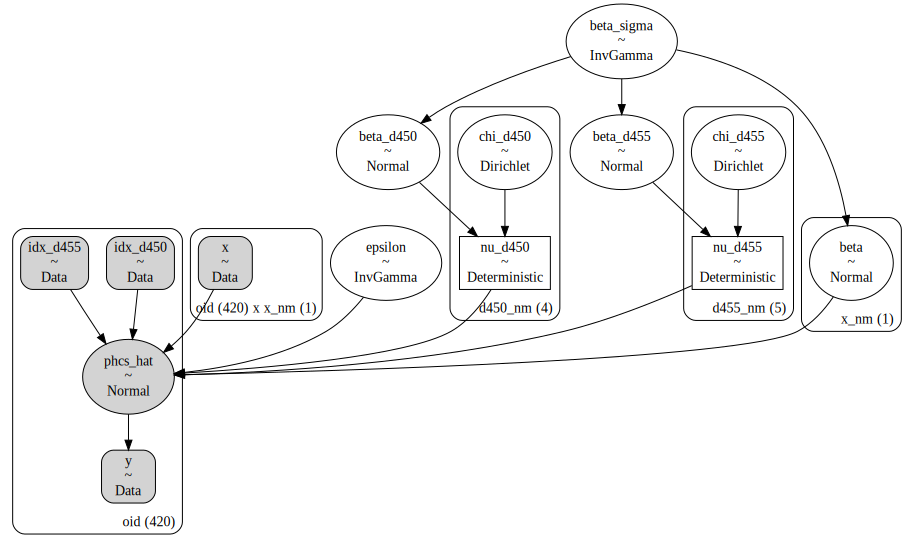

point={'beta_sigma_log__': array(0.), 'beta': array([0.]), 'beta_d450': array(0.), 'chi_d450_simplex__': array([0., 0., 0.]), 'beta_d455': array(0.), 'chi_d455_simplex__': array([0., 0., 0., 0.]), 'epsilon_log__': array(0.)}

No problems found
point={'beta_sigma_log__': array(0.), 'beta': array([0.]), 'beta_d450': array(0.), 'chi_d450_simplex__': array([0., 0., 0.]), 'beta_d455': array(0.), 'chi_d455_simplex__': array([0., 0., 0., 0.]), 'epsilon_log__': array(0.)}

No problems found


In [39]:
display(pm.model_to_graphviz(mdlb, formatting="plain"))
assert_no_rvs(mdlb.logp())
mdlb.debug(fn="logp", verbose=True)
mdlb.debug(fn="random", verbose=True)

## 2.2 Sample Prior Predictive, View Diagnostics

In [40]:
with mdlb:
    idb = pm.sample_prior_predictive(
        var_names=RVS_PPC + rvs_simple + rvs_d450 + rvs_d455,
        samples=2000,
        return_inferencedata=True,
        random_seed=42,
    )

### 2.2.1 In-Sample Prior PPC (Retrodictive Check)

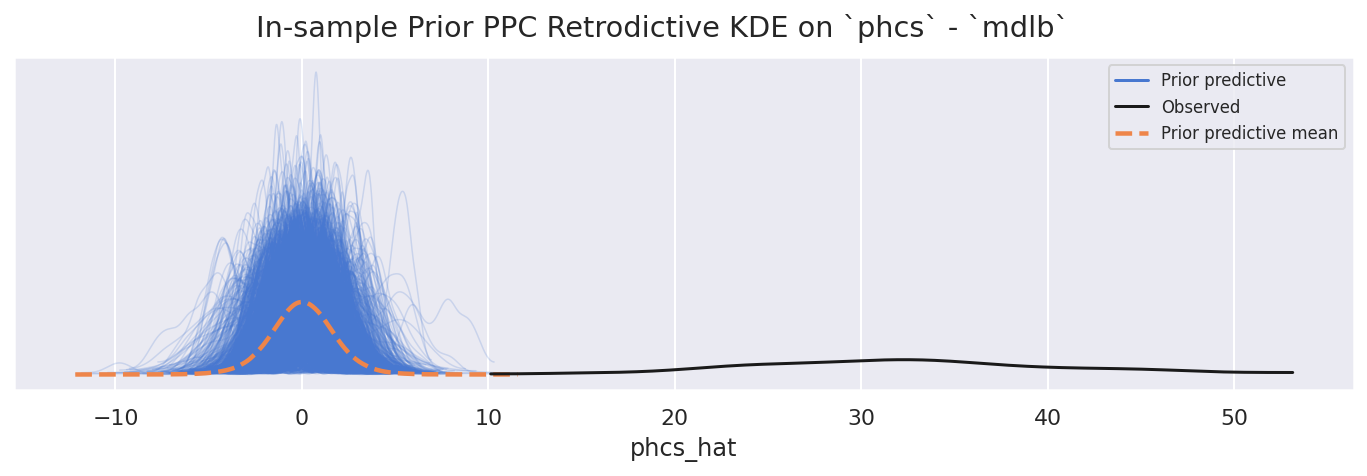

In [41]:
f = plot_ppc_retrodictive(idb, "prior", "mdlb", "phcs")

**Observe:**

+ Values are wrong as expected, but range is reasonable

### 2.2.2 Quick look at selected priors

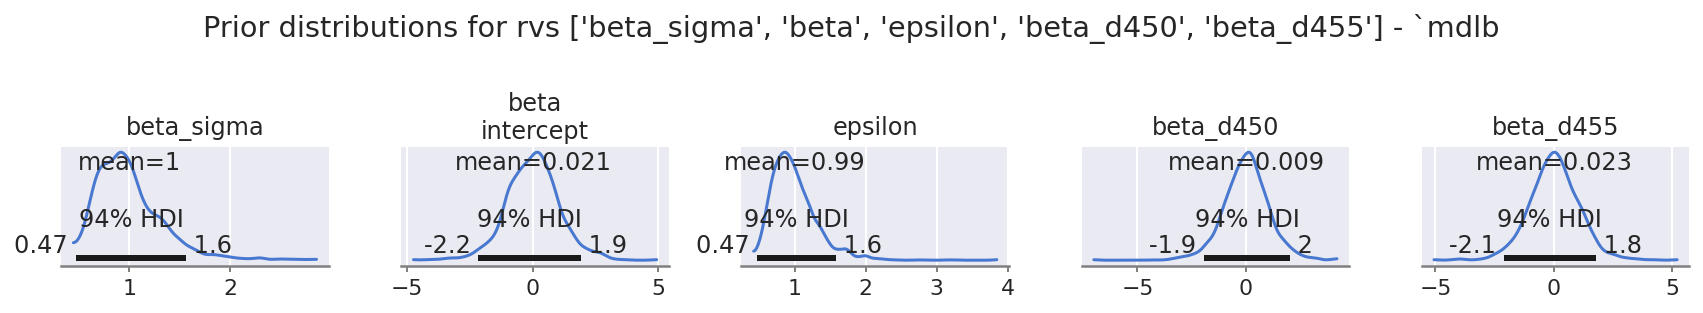

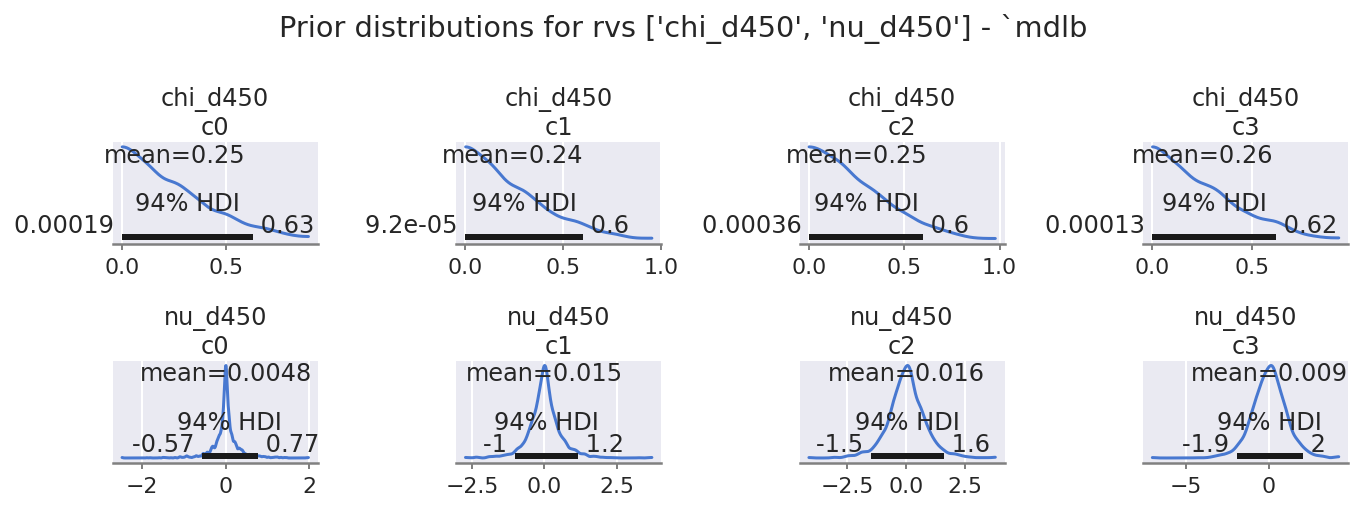

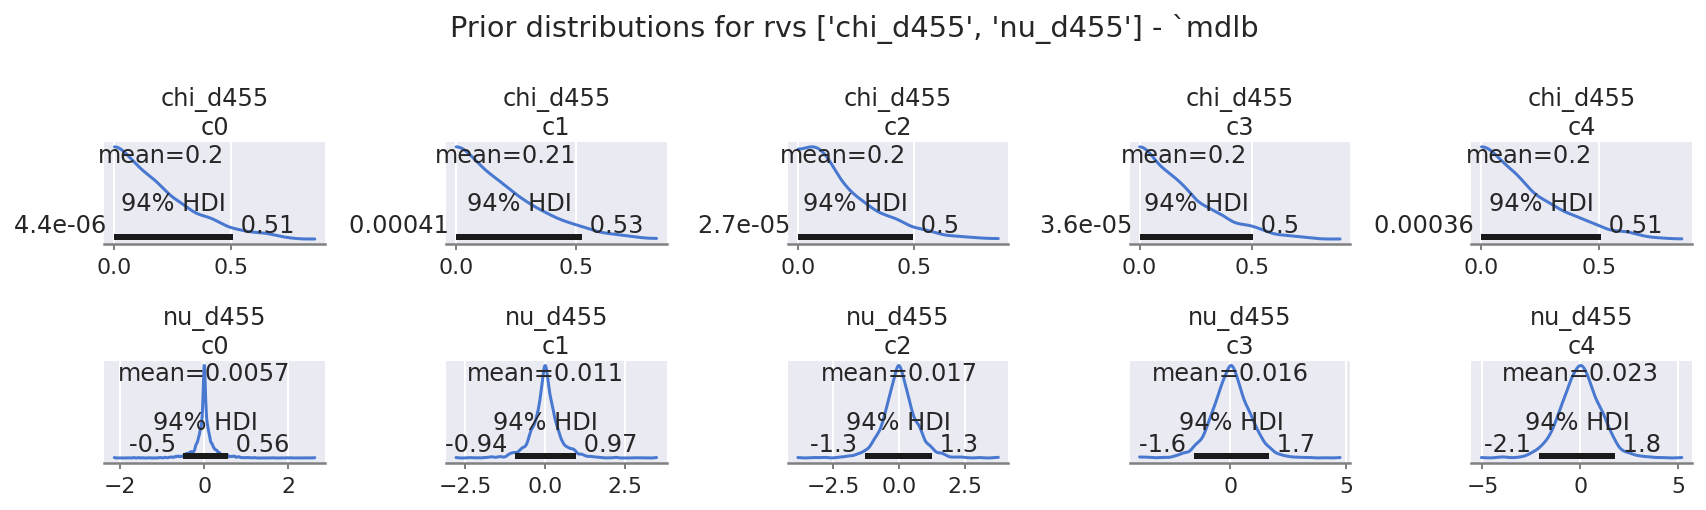

In [42]:
f = plot_posterior(idb, "prior", rvs=rvs_simple, mdlname="mdlb", n=5, nrows=1)
f = plot_posterior(idb, "prior", rvs=rvs_d450, mdlname="mdlb", n=4 * 2, nrows=2)
f = plot_posterior(idb, "prior", rvs=rvs_d455, mdlname="mdlb", n=5 * 2, nrows=2)

**Observe:**

+ Several new parameters!
+ `beta_sigma`, `beta: (levels)`, `epsilon`: all have reasonable prior ranges as specified
+ `*_d450`:
  + `chi_*`: obey the simplex constraint of the Dirichlet and span the range
  + `nu_*`: all reasonable as specified, note the ordering already present in the prior
+ `*_d455`:
  + `chi_*`: obey the simplex constraint of the Dirichlet and span the range
  + `nu_*`: all reasonable as specified, note the ordering already present in the prior

## 2.3 Sample Posterior, View Diagnostics

### 2.3.1 Sample Posterior and PPC

In [43]:
SAMPLE_KWS["target_accept"] = 0.9  # raise to mitigate some minor divergences
with mdlb:
    idb.extend(pm.sample(**SAMPLE_KWS), join="right")
    idb.extend(
        pm.sample_posterior_predictive(trace=idb.posterior, var_names=RVS_PPC),
        join="right",
    )

Output()

Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

### 2.3.2 Traces

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_sigma       12.461  2.665   8.069   17.357      0.088    0.065    1123.0   
beta[intercept]  40.931  2.333  37.286   45.083      0.114    0.081     495.0   
epsilon           6.865  0.231   6.437    7.307      0.006    0.004    1573.0   
beta_d450        -9.488  2.167 -13.659   -5.991      0.087    0.066     767.0   
beta_d455        -7.413  2.038 -11.431   -4.016      0.083    0.062     721.0   
chi_d450[c0]      0.147  0.121   0.000    0.370      0.005    0.004     558.0   
chi_d450[c1]      0.466  0.119   0.240    0.675      0.004    0.003    1051.0   
chi_d450[c2]      0.222  0.102   0.017    0.393      0.003    0.002    1340.0   
chi_d450[c3]      0.165  0.100   0.000    0.335      0.002    0.001    2055.0   
nu_d450[c0]      -1.583  1.692  -4.630   -0.001      0.080    0.057     534.0   
nu_d450[c1]      -5.850  1.931  -9.404   -2.965      0.080    0.060     769.0   
nu_d450[c2]      -7.888  1.946 -11.524   -4.873      0.083    0.062     753.0   
nu_d450[c3]      -9.488  2.167 -13.659   -5.991      0.087    0.066     767.0   
chi_d455[c0]      0.150  0.125   0.000    0.387      0.005    0.003     688.0   
chi_d455[c1]      0.324  0.122   0.079    0.545      0.003    0.002    1354.0   
chi_d455[c2]      0.059  0.056   0.000    0.164      0.001    0.001    1106.0   
chi_d455[c3]      0.303  0.133   0.061    0.550      0.004    0.003     953.0   
chi_d455[c4]      0.164  0.111   0.000    0.355      0.003    0.002    1682.0   
nu_d455[c0]      -1.261  1.363  -3.804   -0.001      0.057    0.041     611.0   
nu_d455[c1]      -3.597  1.680  -6.773   -0.913      0.068    0.051     726.0   
nu_d455[c2]      -4.010  1.684  -7.227   -1.288      0.068    0.051     764.0   
nu_d455[c3]      -6.185  1.868  -9.731   -2.857      0.072    0.054     809.0   
nu_d455[c4]      -7.413  2.038 -11.431   -4.016      0.083    0.062     721.0   

                 ess_tail  r_hat  
beta_sigma          838.0   1.00  
beta[intercept]     499.0   1.00  
epsilon            1405.0   1.00  
beta_d450           610.0   1.01  
beta_d455           471.0   1.01  
chi_d450[c0]        608.0   1.01  
chi_d450[c1]       1249.0   1.00  
chi_d450[c2]        701.0   1.00  
chi_d450[c3]       1202.0   1.00  
nu_d450[c0]         638.0   1.01  
nu_d450[c1]         551.0   1.01  
nu_d450[c2]         552.0   1.01  
nu_d450[c3]         610.0   1.01  
chi_d455[c0]        847.0   1.00  
chi_d455[c1]        807.0   1.00  
chi_d455[c2]        834.0   1.00  
chi_d455[c3]        708.0   1.01  
chi_d455[c4]       1095.0   1.00  
nu_d455[c0]         697.0   1.01  
nu_d455[c1]         616.0   1.01  
nu_d455[c2]         627.0   1.01  
nu_d455[c3]         631.0   1.00  
nu_d455[c4]         471.0   1.01

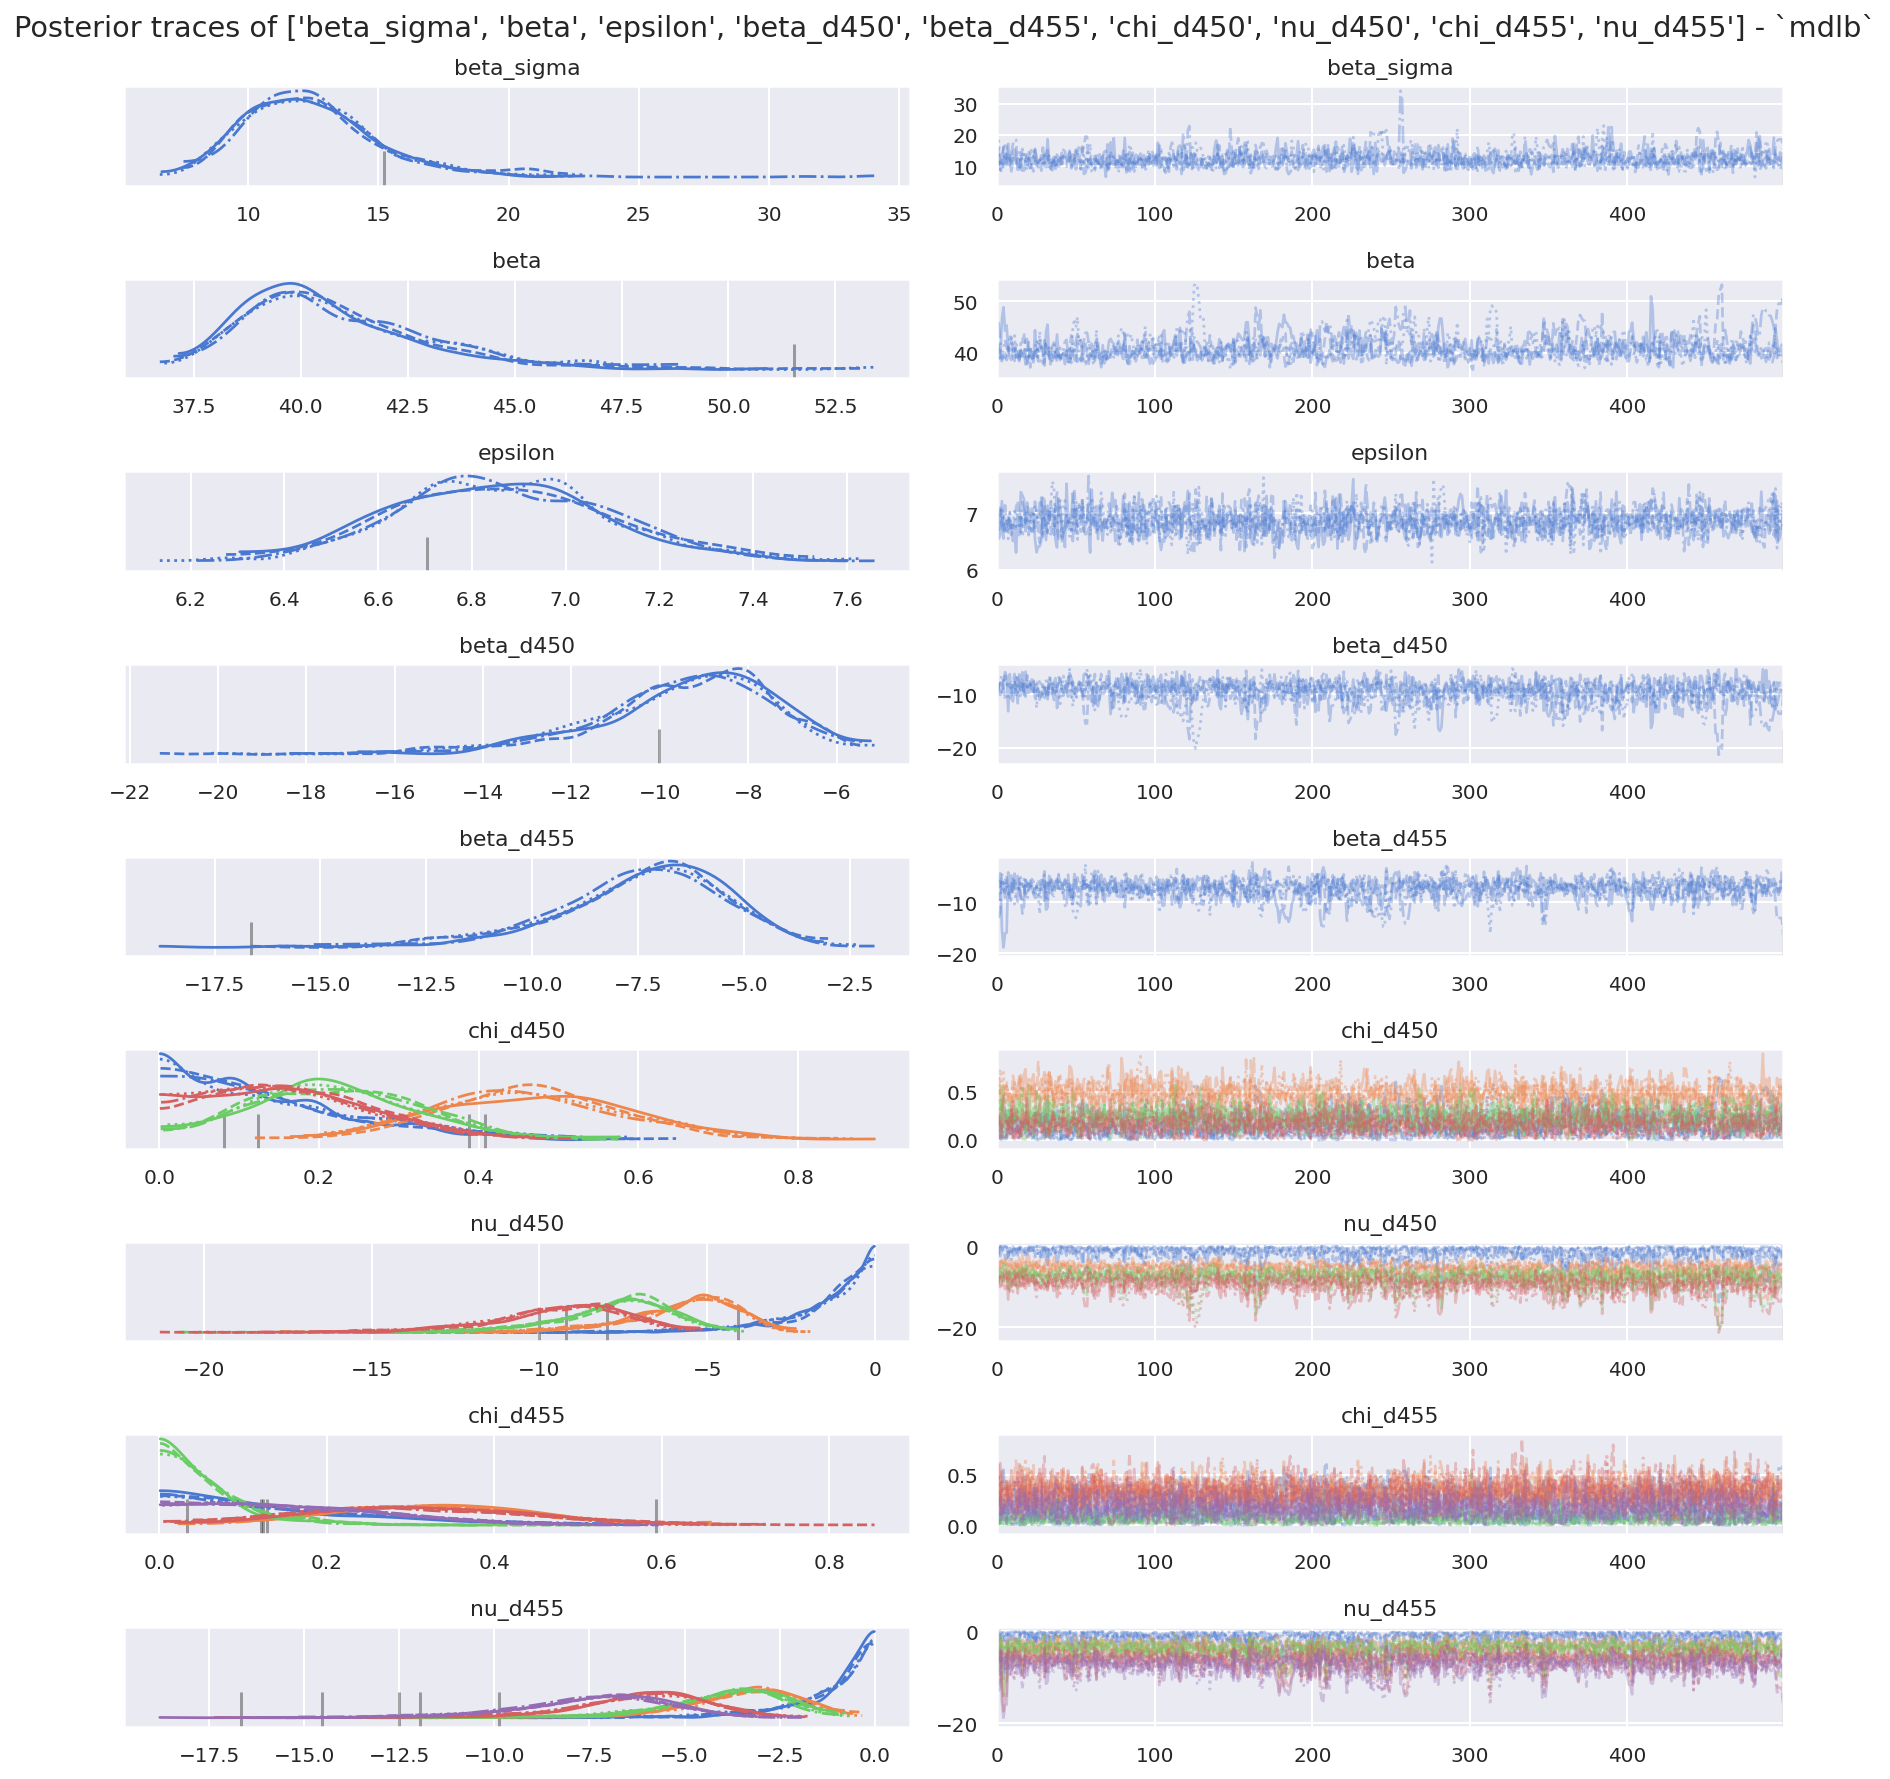

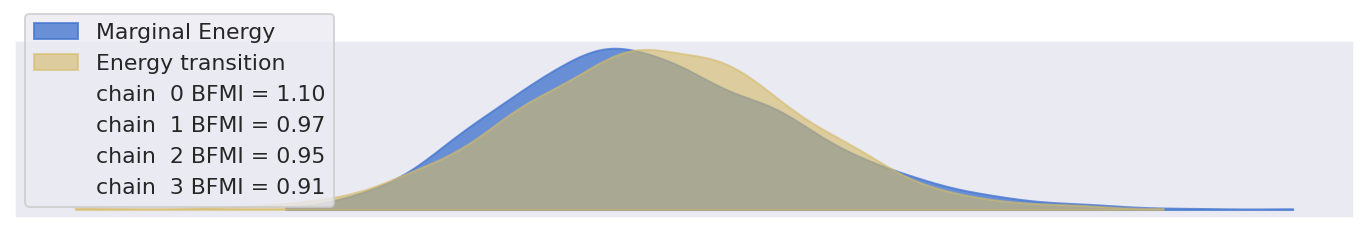

In [44]:
f = plot_traces_and_display_summary(idb, rvs=rvs_simple + rvs_d450 + rvs_d455, mdlname="mdlb")

**Observe:**

+ Samples well-mixed and well-behaved, but note we raised `target_accept=0.9` to mitigate / avoid divergences seen at `0.8`
  + `ess_bulk` a little low, `r_hat` is okay
+ Marginal energy | energy transition looks reasonable
  + `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

### 2.3.3 In-Sample Posterior PPC (Retrodictive Check)

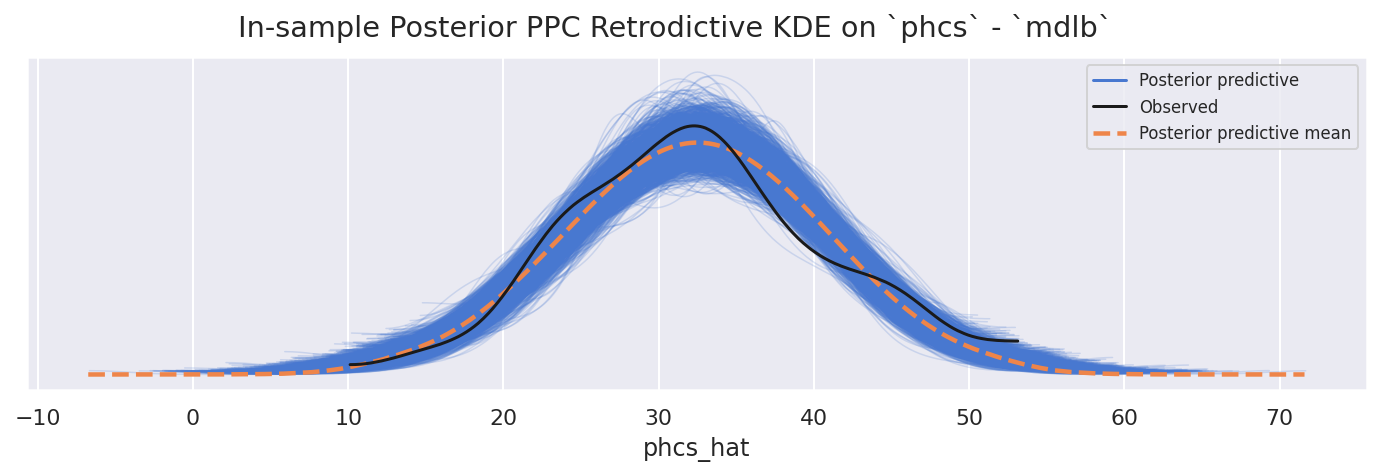

In [45]:
f = plot_ppc_retrodictive(idb, "posterior", "mdlb", "phcs")

**Observe:**

+ In-sample PPC `phcs_hat` tracks the observed `phcs` moderately well: slightly overdispersed, perhaps a likelihood
  with fatter tails would be more appropriate (e.g. StudentT)

### 2.3.4 In-Sample PPC LOO-PIT

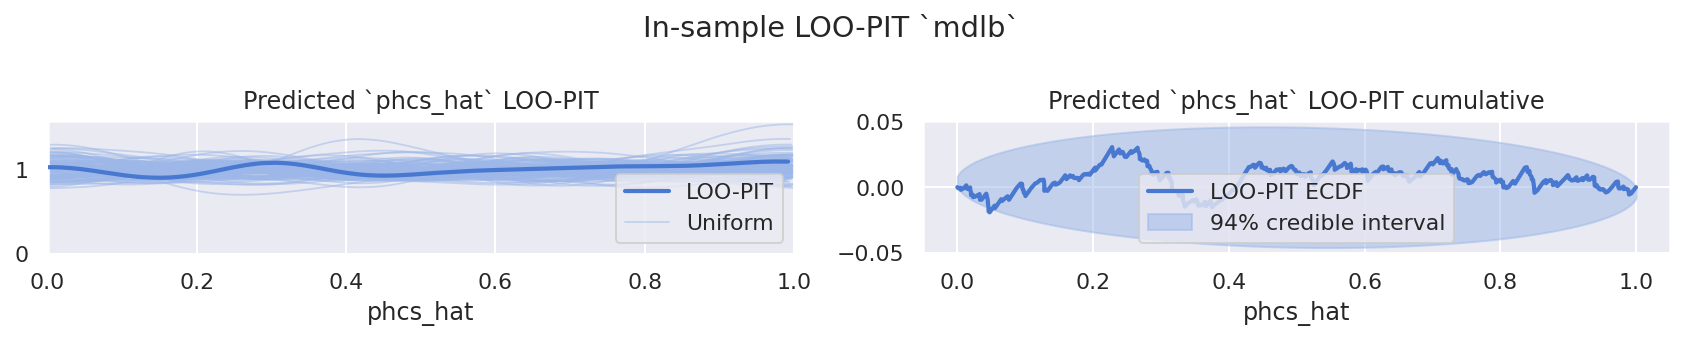

In [46]:
f = plot_loo_pit(idb, "mdlb")

**Observe:**

+ `LOO-PIT` looks good, again slightly overdispersed but acceptable for use

### 2.3.5 Compare Log-Likelihood vs Other Models

rank     elpd_loo     p_loo  elpd_diff    weight         se       dse  \
mdlb     0 -1412.668795  6.413259   0.000000  0.963526  14.817436  0.000000   
mdla     1 -1415.136416  3.759675   2.467621  0.036474  14.837808  2.288289   

      warning scale  
mdlb    False   log  
mdla    False   log

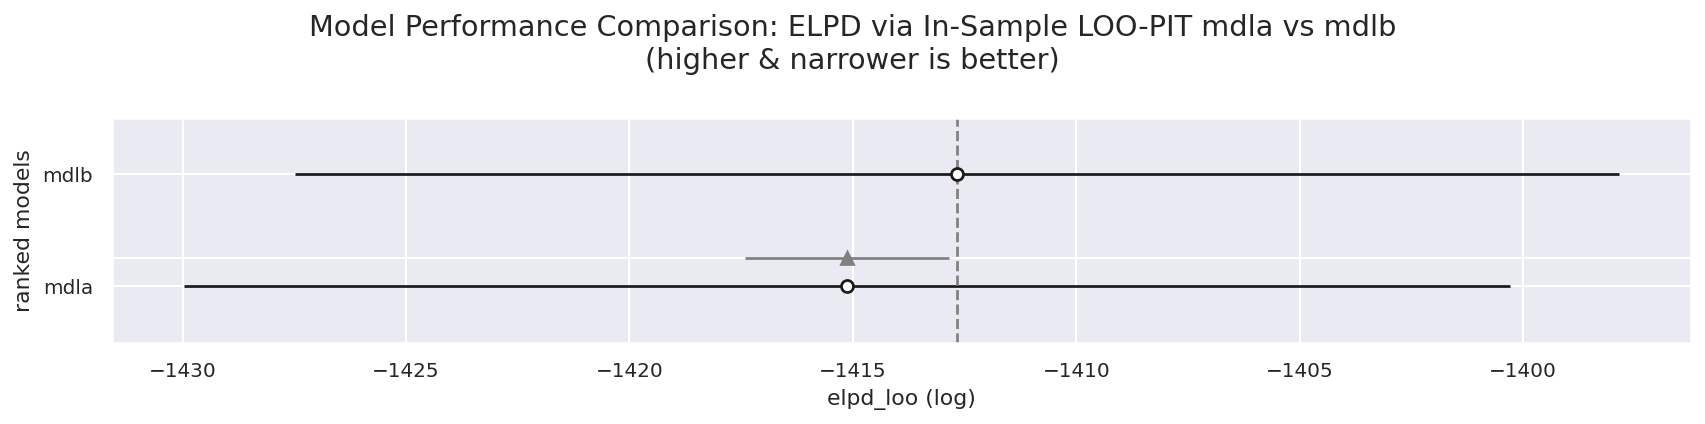

In [47]:
def plot_compare_log_likelihood(idata_dict={}, y_hat="phcs_hat") -> plt.figure:
    """Convenience to plot comparison for a dict of idatas"""
    dfcomp = az.compare(idata_dict, var_name=y_hat, ic="loo", method="stacking", scale="log")
    f, axs = plt.subplots(1, 1, figsize=(12, 2.4 + 0.3 * len(idata_dict)))
    _ = az.plot_compare(dfcomp, ax=axs, title=False, textsize=10, legend=False)
    _ = f.suptitle(
        "Model Performance Comparison: ELPD via In-Sample LOO-PIT "
        + " vs ".join(list(idata_dict.keys()))
        + "\n(higher & narrower is better)"
    )
    _ = f.tight_layout()
    display(dfcomp)
    return f


f = plot_compare_log_likelihood(idata_dict={"mdla": ida, "mdlb": idb})

**Observe:**

+ Our new ordinal-respecting `mdlb` appears to be the winner, taking nearly all the weight and a higher `elpd_loo`

## 2.4 Evaluate Posterior Parameters

### 2.4.1 Univariate

Lots of parameters, let's take our time

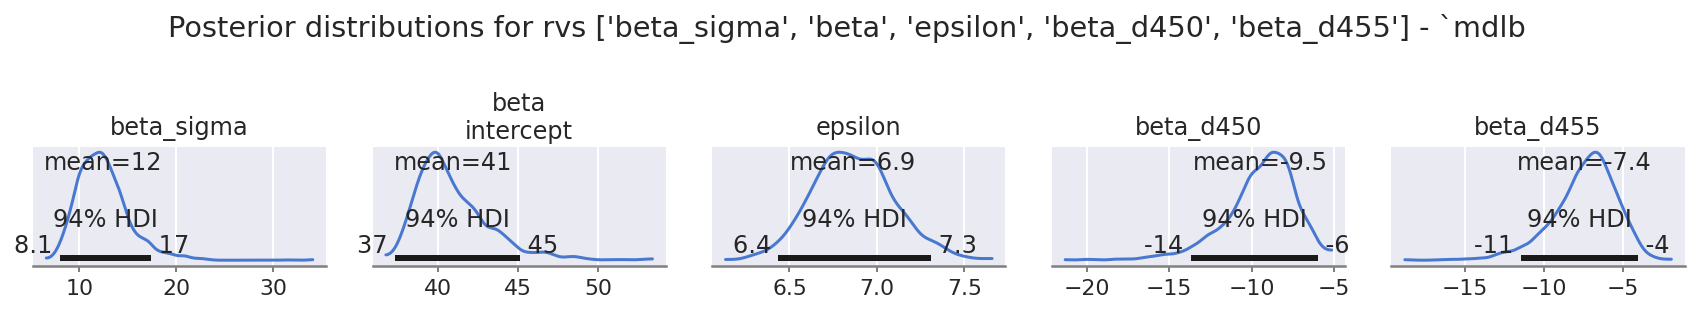

In [48]:
f = plot_posterior(idb, "posterior", rvs=rvs_simple, mdlname="mdlb", n=5, nrows=1)

**Observe:**

+ `beta_sigma`: `E ~ 30` indicates need for high variance in locations of `beta`s
+ `beta: intercept`: `E ~ 41` confirms the bulk of the variance in `beta`s locations is simply due to the intercept
    offset required to get the zscored values into range of `phcs`, no problem
+ `epsilon`: `E ~ 7` indicates quite a lot of variance still in the data, not yet handled by a modelled feature
+ `beta: d450`: `E ~ -9` negative, HDI94 does not span 0, substantial effect, smooth central distribution:
  + Higher indexes of `d450_idx` create a reduction in `phcs_hat`
+ `beta: d455`: `E ~ -7` negative, HDI94 does not span 0, substantial effect, smooth central distribution
  + Higher indexes of `d455_idx` create a reduction in `phcs_hat`

In general the bigger coefficient values here (vs `mdla`) suggest more disrimination between the values in the data and
better performance

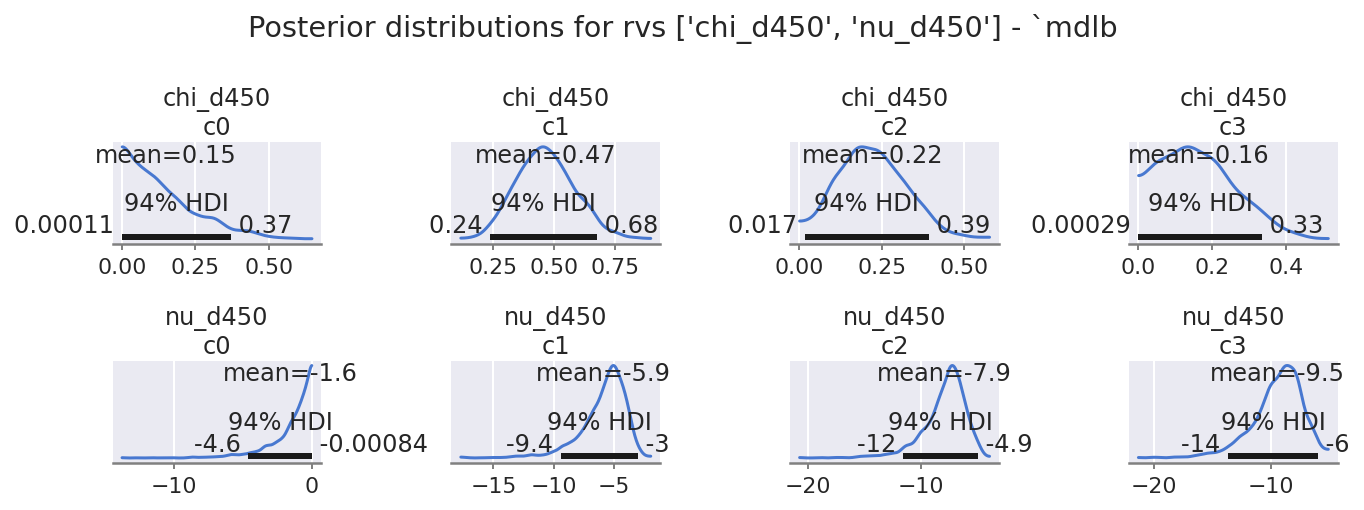

In [49]:
f = plot_posterior(idb, "posterior", rvs=rvs_d450, mdlname="mdlb", n=4 * 2, nrows=2)

**Observe:**

Interesting pattern:
+ `chi_d450`: Non-linear response throughout the range
+ `nu_d450`: The non-linear effect `beta * chi.csum()` is clear, in particular `c0` is far from the trend of `c1, c2, c3`

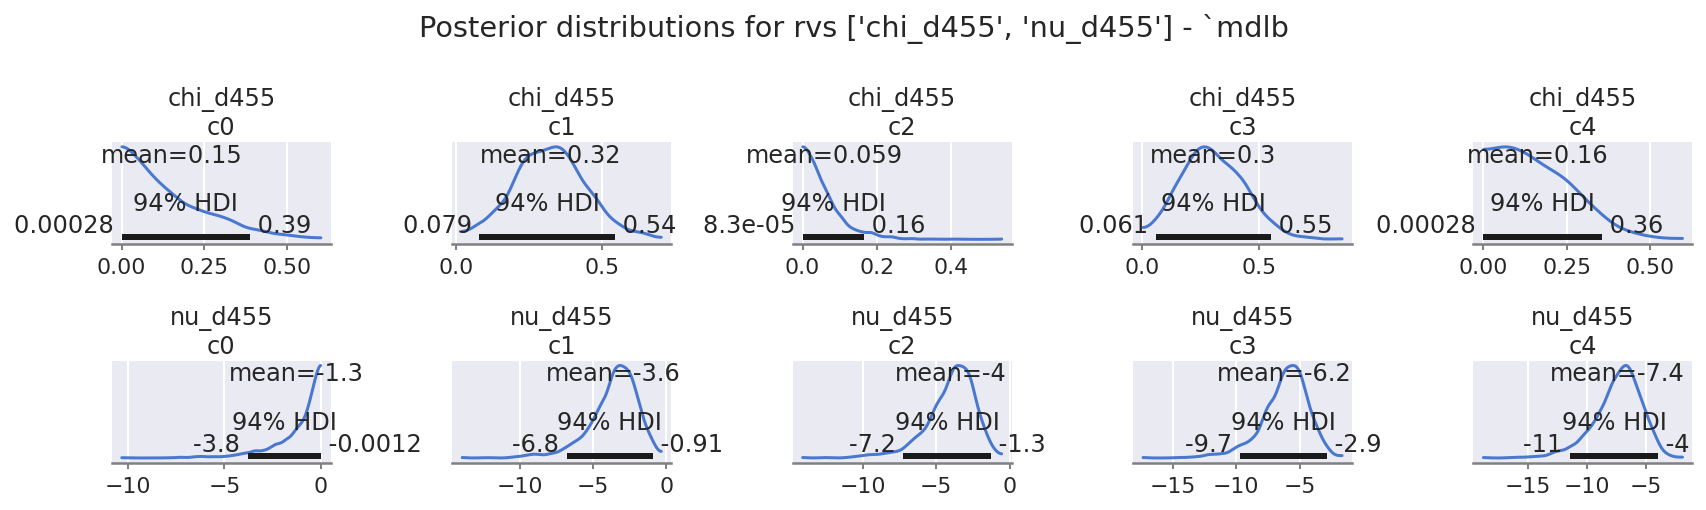

In [50]:
f = plot_posterior(idb, "posterior", rvs=rvs_d455, mdlname="mdlb", n=5 * 2, nrows=2)

**Observe:**

Interesting pattern:
+ `chi_d455`: Non-linear response throughout the range
+ `nu_d455`: The non-linear effect `beta * chi.csum()` is clear, in particular `c2` is almost the same as `c1`

> Let's see those levels forestplotted to make even more clear

##### Monotonic priors forestplot

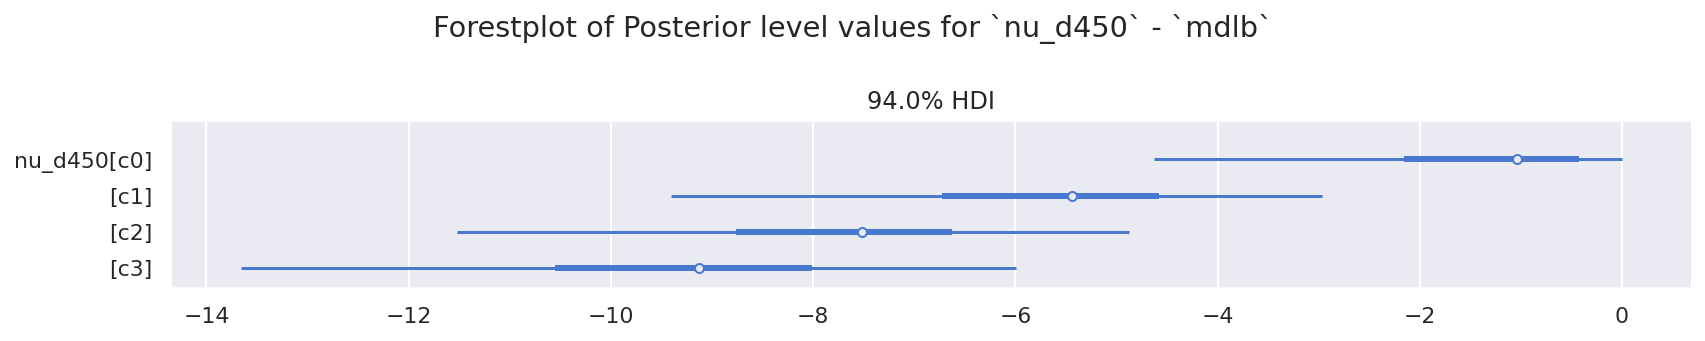

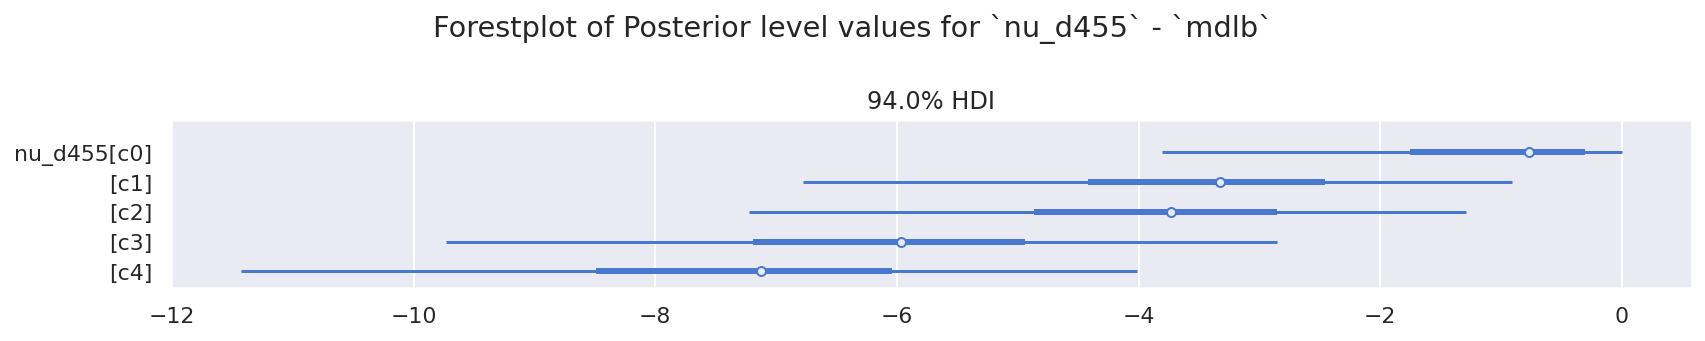

In [51]:
def plot_posterior_forest(idata, group="posterior", rv="beta", mdlname="mdla"):
    """Convenience forestplot posterior (or prior) KDE"""
    f, axs = plt.subplots(1, 1, figsize=(12, 2.4))
    _ = az.plot_forest(idata[group], var_names=[rv], ax=axs, combined=True)
    _ = f.suptitle(f"Forestplot of {group.title()} level values for `{rv}` - `{mdlname}`")
    _ = f.tight_layout()
    return f


f = plot_posterior_forest(idb, "posterior", "nu_d450", "mdlb")
f = plot_posterior_forest(idb, "posterior", "nu_d455", "mdlb")

**Observe:**

Here we see the same patterns in more detail, inparticular:
+ `nu_d450`: `c0` is an outlier with disproportionately less impact than `c1, c2, c3`
+ `nu_d455`: `c1, c2` overlap strongly and so have very similar impact to one another

## 2.5 Create PPC Forecast on simplified `forecast` set

Just for completeness, just compare to Figure 3 in the Bürkner paper and Rochford's
blogpost.

Those plots summarize to a mean though, which seems unneccesary - let's improve it a little.

### 2.5.1 Replace dataset with `dffx`, rebuild, and sample PPC

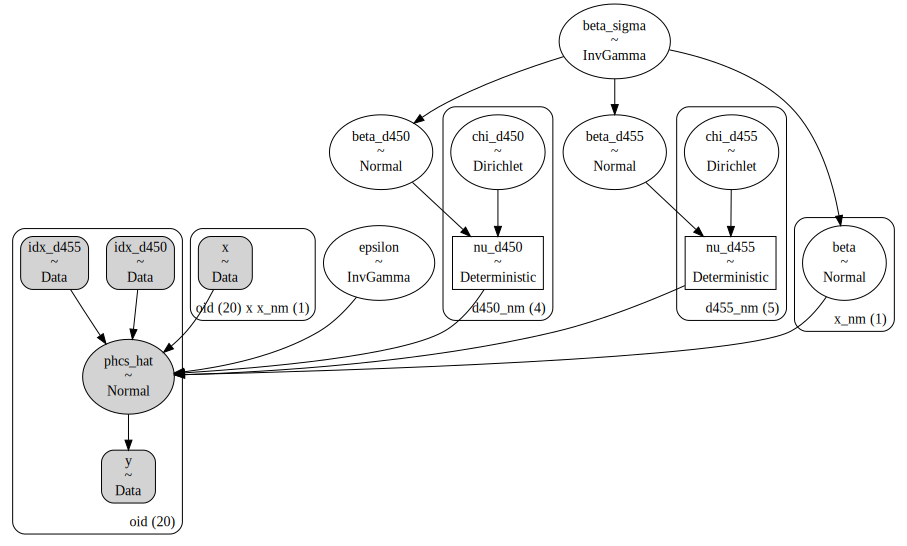

point={'beta_sigma_log__': array(0.), 'beta': array([0.]), 'beta_d450': array(0.), 'chi_d450_simplex__': array([0., 0., 0.]), 'beta_d455': array(0.), 'chi_d455_simplex__': array([0., 0., 0., 0.]), 'epsilon_log__': array(0.)}

No problems found
point={'beta_sigma_log__': array(0.), 'beta': array([0.]), 'beta_d450': array(0.), 'chi_d450_simplex__': array([0., 0., 0.]), 'beta_d455': array(0.), 'chi_d455_simplex__': array([0., 0., 0., 0.]), 'epsilon_log__': array(0.)}

No problems found


In [52]:
COORDS_F = deepcopy(COORDS)
COORDS_F["oid"] = dffx.index.values
mdlb.set_data("y", dffx[ft_y].values, coords=COORDS_F)
mdlb.set_data("x", dffx[fts_x].values, coords=COORDS_F)
mdlb.set_data("idx_d450", dffx["d450_idx"].values, coords=COORDS_F)
mdlb.set_data("idx_d455", dffx["d455_idx"].values, coords=COORDS_F)

display(pm.model_to_graphviz(mdlb, formatting="plain"))
assert_no_rvs(mdlb.logp())
mdlb.debug(fn="logp", verbose=True)
mdlb.debug(fn="random", verbose=True)

In [53]:
with mdlb:
    idb_ppc = pm.sample_posterior_predictive(
        trace=idb.posterior, var_names=RVS_PPC, predictions=True
    )

Output()

### 2.5.2 View Predictions

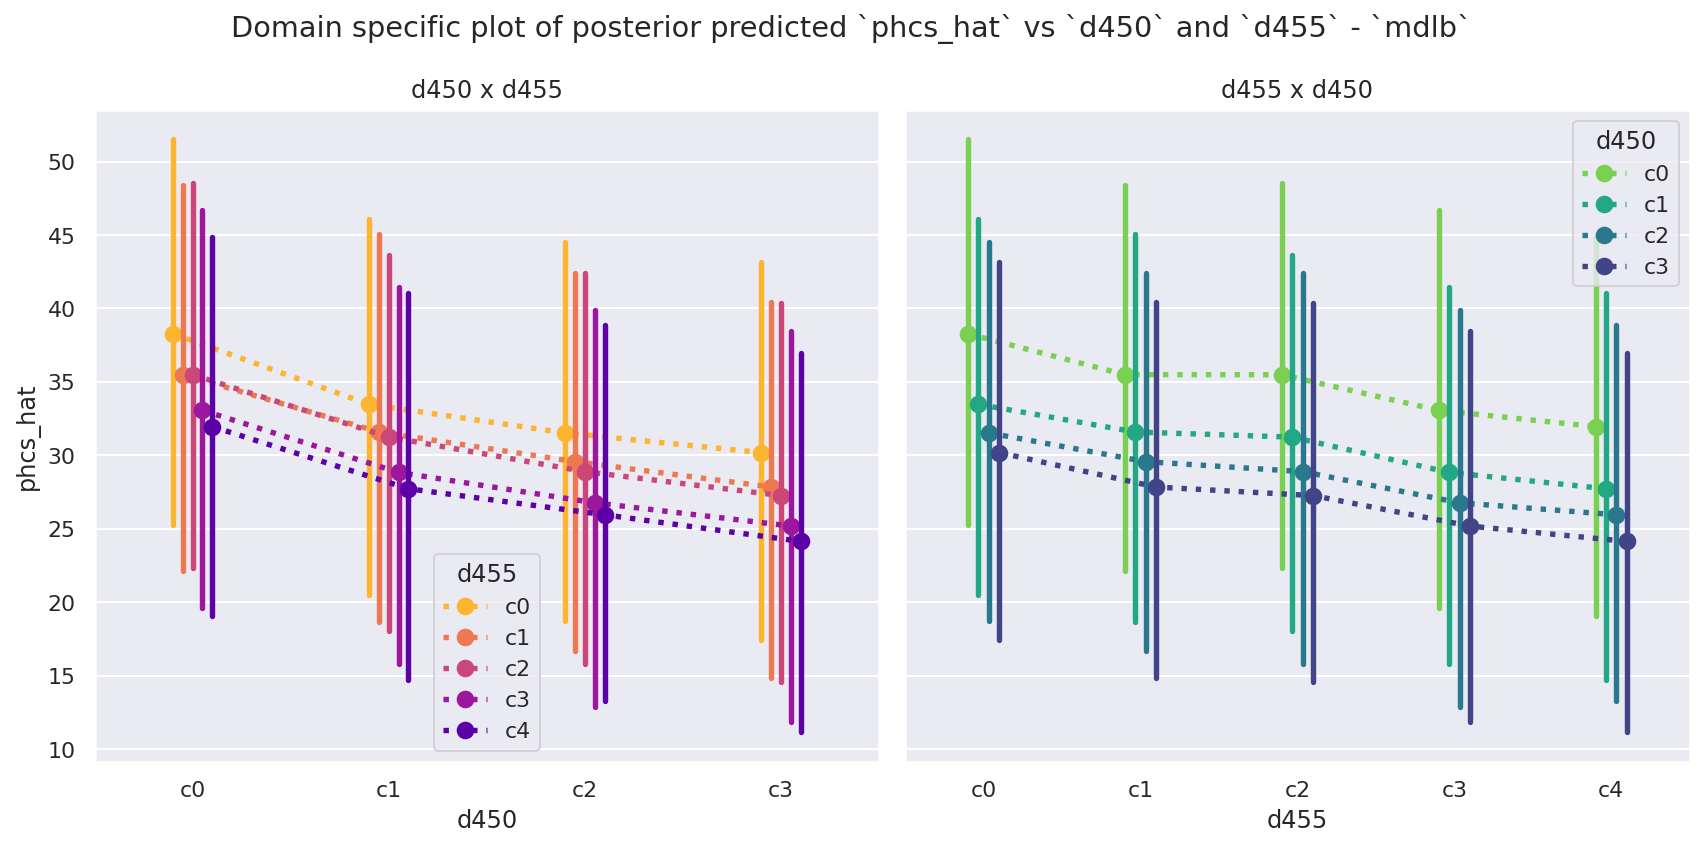

In [54]:
plot_predicted_phcshat_d450_d455(idata=idb_ppc, mdlname="mdlb")

**Observe:**

+ Compare this to Section 1.5.2 above, and the plots in
  [Austin Rochford's notebook](https://austinrochford.com/posts/2018-11-10-monotonic-predictors.html)
+ We see the non-linear responses and non-equal spacings of `d450` and of `d455` when treated as ordinal categories
+ In particular, note the behaviours we already saw in the posterior plots
  + LHS plot `d450`: all points for `c0` are all higher than the plot in Section 1.5.2 (also note the overlap of `d455: c1, c2` levels in the shaded points)
  + RHS plot `d455`: all points for `c1, c2` overlap strongly (also note `d455 c0` outlying)
+ Note here we plot the full posteriors on each datapoint (rather than summarise to a mean) which emphasises
  the large amount of variance still in the data & model

---

---

# Errata

## Authors

+ Created by [Jonathan Sedar](https://github.com/jonsedar) in Oct 2024

## Reference

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [55]:
# tested running on Google Colab 2024-10-27
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Oct 27 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pandas    : 2.2.2
pymc      : 5.16.2
arviz     : 0.19.0
pytensor  : 2.25.5
pyreadr   : 0.5.2
tarfile   : 0.9.0
seaborn   : 0.13.2
matplotlib: 3.7.1
numpy     : 1.26.4

Watermark: 2.5.0



:::{include} ../page_footer.md
:::